# Introduction and Business Understanding

More and more electric vehicles can be seen on the streets as they are slowly replacing traditional vehicles with combustion engines. Electric vehicles can do without a fuel tank; instead they have a powerful battery which is used both for moving the vehicle as well as for powering other consumers, such as heating, airconditioning, multimedia, and infotainment. 

Most drivers of electric vehicles are well aware of the "State of Charge" that shows how much power is left in the battery throughout a trip. The fear of a breakdown due to an empty battery has even received its own terminology: "Range Anxiety". 

This Data Science project focusses on the "State of Charge" (SoC) of electric vehicles, explores dependencies to measures taken during a vehicle's trip, and makes predictions of the required battery power for a vehicle's trip. 

For the analysis, a dataset is used which includes 70 trips of a BMW i3 in 2019 in and around Munich, Germany. Throughout the trips a variety of measures have been recorded, such as velocity, acceleration, ambient temperature, elevation, heating, air conditioning, motor torque, and more.

## Structure of this Notebook

- Introduction and Business Understanding
- Importing Required Libraries
- Step 1 | Loading Data
- Step 2 | Data Exploration, Data Cleansing, Data Visualization
- Step 3 | Data Preparation
- Step 4 | Modeling and Prediction
- Step 5 | Evaluation
- What Remains to be Said

# Importing Required Libraries

In [1]:
# Import libraries
import pandas as pd

from os import listdir
from os.path import isfile, join

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_squared_error

C:\ProgramData\Anaconda\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Step 1 | Loading Data 

In [2]:
# Retrieve csv filenames from battery_and_heating_data directory
tripdata = []
for f in listdir('battery_and_heating_data'):
    if f[-3:] == 'csv':
        tripdata.append(f)

In [3]:
# Read in all tripdata including the trip's id
trip_df = pd.DataFrame()
for f in tripdata:
    new_df = pd.read_csv(filepath_or_buffer=('battery_and_heating_data/'+f), sep=';', engine='python')
    new_df['trip_id'] = f[:-4]
    
    trip_df = pd.concat([trip_df, new_df], sort=False)

print(trip_df.shape)
trip_df.head()

(1094793, 51)


,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,Temperature Footweel Co-Driver [°C],Temperature Feetvent Co-Driver [°C],Temperature Feetvent Driver [°C],Temperature Head Co-Driver [°C],Temperature Head Driver [°C],Temperature Vent right [°C],Temperature Vent central right [°C],Temperature Vent central left [°C],Temperature Vent right [°C],Velocity [km/h]]]
0,0.0,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.20,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.1,0.0,574.0,0.0,0.0,0.00,0.0,391.4,-2.21,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.2,0.0,574.0,0.0,0.0,-0.01,0.0,391.4,-2.26,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.3,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.30,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.4,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.30,21.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Read in trip overview data
trip_overview = pd.read_excel('battery_and_heating_data/Overview.xlsx', index_col=None)
trip_overview.head()

,Trip,Date,Route/Area,Weather,Battery Temperature (Start) [°C],Battery Temperature (End),Battery State of Charge (Start),Battery State of Charge (End),Unnamed: 8,Ambient Temperature (Start) [°C],Target Cabin Temperature,Distance [km],Duration [min],Unnamed: 13,Fan,Note
0,TripA01,2019-06-25_13-21-14,Munich East,sunny,21.0,22.0,0.863,0.803,0.060,25.5,23.0,7.427690,16.820000,NaN,"Automatic, Level 1",NaN
1,TripA02,2019-06-25_14-05-31,Munich East,sunny,23.0,26.0,0.803,0.673,0.130,32.0,23.0,23.509709,23.550000,NaN,"Automatic, Level 1",Target Cabin Temperature changed
2,TripA03,2019-06-28_10-02-15,Munich East,sunny,24.0,25.0,0.835,0.751,0.084,21.5,27.0,12.820846,11.180000,NaN,"Automatic, Level 1",Target Cabin Temperature changed
3,TripA04,2019-06-28_10-13-30,Munich East,sunny,25.0,27.0,0.751,0.667,0.084,24.0,22.0,10.727491,6.870000,NaN,"Automatic, Level 1",NaN
4,TripA05,2019-06-28_10-20-26,Munich East,sunny,27.0,27.0,0.667,0.602,0.065,24.5,24.0,12.393223,22.776667,NaN,"Automatic, Level 1",NaN


# Step 2 | Data Exploration, Data Cleansing, Data Visualization

To start our data exploration journey, we take the trip_df dataframe and run first queries against it.

In [5]:
number_of_trips = len(trip_df['trip_id'].unique())
print('The dataset contains ', number_of_trips, ' individual trips.')

The dataset contains  70  individual trips.


Upon checking the trips dataset for null values we find:
- (1) Column 'Unnamed: 23' has 99.9999 % missing values. We will remove this column.
- (2) There are two columns for velocity: 'Velocity [km/h]]]' and 'Velocity [km/h]'. We will combine them into one.
- (3) There are two columns for the right vent's temperature: 'Temperature Vent right [°C] ' and 'Temperature Vent right [°C]'. We will investigate further.

In [6]:
(trip_df.isnull().sum() / trip_df.shape[0]).sort_values(ascending=False)

Unnamed: 23                               0.999999
Velocity [km/h]]]                         0.984994
Coolant Volume Flow +500 [l/h]            0.453085
Temperature Defrost central right [°C]    0.431442
Ambient Temperature Sensor [°C]           0.431442
Temperature Coolant Heater Inlet [°C]     0.431442
Temperature Coolant Heater Outlet [°C]    0.431442
Temperature Heat Exchanger Outlet [°C]    0.431442
Temperature Defrost lateral left [°C]     0.431442
Temperature Defrost lateral right [°C]    0.431442
Temperature Defrost central left [°C]     0.431442
Temperature Defrost central [°C]          0.431442
Temperature Footweel Driver [°C]          0.431442
Temperature Footweel Co-Driver [°C]       0.431442
Temperature Feetvent Co-Driver [°C]       0.431442
Temperature Feetvent Driver [°C]          0.431442
Temperature Head Co-Driver [°C]           0.431442
Temperature Head Driver [°C]              0.431442
Temperature Vent right [°C]               0.431442
Temperature Vent central right 

In [7]:
# (1) Removing (almost) empty column 'Unnamed: 23'
trip_df.drop(columns=['Unnamed: 23'], inplace=True)

In [8]:
# (2) Combining two velocity columns into one
## Checking that the two velocity columns do not overlap
print('Number of empty values in column \'Velocity [km/h]\' when \'Velocity [km/h]]]\' is empty: ', 
      trip_df[trip_df['Velocity [km/h]]]'].isna()]['Velocity [km/h]'].isna().sum())
print('Number of empty values in column \'Velocity [km/h]]]\' when \'Velocity [km/h]\' is empty: ', 
      trip_df[trip_df['Velocity [km/h]'].isna()]['Velocity [km/h]]]'].isna().sum())

## Moving content of 'Velocity [km/h]]]' into 'Velocity [km/h]'
trip_df_v = trip_df[trip_df['Velocity [km/h]'].isna()].copy()
trip_df_v['Velocity [km/h]'] = trip_df_v['Velocity [km/h]]]']
trip_df = pd.concat([trip_df[trip_df['Velocity [km/h]]]'].isna()], trip_df_v])

## Removing no longer needed column 'Velocity [km/]]]'
trip_df.drop(columns=['Velocity [km/h]]]'], inplace=True)

Number of empty values in column 'Velocity [km/h]' when 'Velocity [km/h]]]' is empty:  0
Number of empty values in column 'Velocity [km/h]]]' when 'Velocity [km/h]' is empty:  0


In [9]:
# (3) Investigating temperature data from right vent
temp_vent_df = trip_df[['trip_id', 'Temperature Vent right [°C]', 'Temperature Vent right [°C] ']].copy()
temp_vent_df['Difference'] = temp_vent_df['Temperature Vent right [°C]'] - temp_vent_df['Temperature Vent right [°C] ']
print(temp_vent_df['Difference'].describe())

trip_df.rename(columns={'Temperature Vent right [°C]': 'Temperature Vent One [°C]', 
                        'Temperature Vent right [°C] ': 'Temperature Vent Two [°C]'},
              inplace=True)

count    622453.000000
mean         -2.079627
std           1.493197
min          -9.860000
25%          -2.310350
50%          -1.920000
75%          -1.400000
max           3.720000
Name: Difference, dtype: float64


We discover that the values of the two 'Temperature Vent right' columns differ from one another. It can thus be assumed that an error occured during data collection when labeling the data columns. Possibly, one of the columns should have been labeled 'Temperature Vent left [°C]'. To avoid missunderstandings during the upcoming data processing, we decide to remove the vents' locations from the column names and label the columns 'Temperature Vent One [°C]' and 'Temperature Vent Two [°C]' instead.

We are now taking a look at the trips in more details. For that we are visualizing mutliple measures over the time of the trip. The measures we choose to visualize are:
- Velocity
- Acceleration
- Throttle
- Motor Torque
- State of Charge

In [10]:
def visualize_trip_over_time(local_trip_id):
    '''
    This function takes in the id of a trip and visualizes five important measures of the trip over time:
    Velocity, Acceleration, Throttle, Motor Torque, and State of Charge.
    
    INPUT:
    local_trip_id: the id of the trip that should be visualized
    
    OUTPUT:
    None
    '''

    this_trip = trip_df[trip_df['trip_id'] == local_trip_id]

    plt.rcParams['figure.figsize'] = [30, 40]
    gs = grd.GridSpec(5, 1)

    vel_ax = plt.subplot(gs[0])
    vel_ax.plot(this_trip['Time [s]'], this_trip['Velocity [km/h]'])
    vel_ax.text(0, this_trip['Velocity [km/h]'].max(), 'Velocity [km/h]', color='black')

    acc_ax = plt.subplot(gs[1])
    acc_ax.plot(this_trip['Time [s]'], this_trip['Longitudinal Acceleration [m/s^2]'])
    acc_ax.text(0, this_trip['Longitudinal Acceleration [m/s^2]'].max(), 'Longitudinal Acceleration [m/s^2]', color='black')

    thr_ax = plt.subplot(gs[2])
    thr_ax.plot(this_trip['Time [s]'], this_trip['Throttle [%]'])
    thr_ax.text(0, this_trip['Throttle [%]'].max(), 'Throttle [%]', color='black')

    mot_ax = plt.subplot(gs[3])
    mot_ax.plot(this_trip['Time [s]'], this_trip['Motor Torque [Nm]'])
    mot_ax.text(0, this_trip['Motor Torque [Nm]'].max(), 'Motor Torque [Nm]', color='black')

    soc_ax = plt.subplot(gs[4])
    soc_ax.plot(this_trip['Time [s]'], this_trip['SoC [%]'])
    soc_ax.text(0, this_trip['SoC [%]'].max(), 'SoC [%]', color='black')
    
    plt.show()

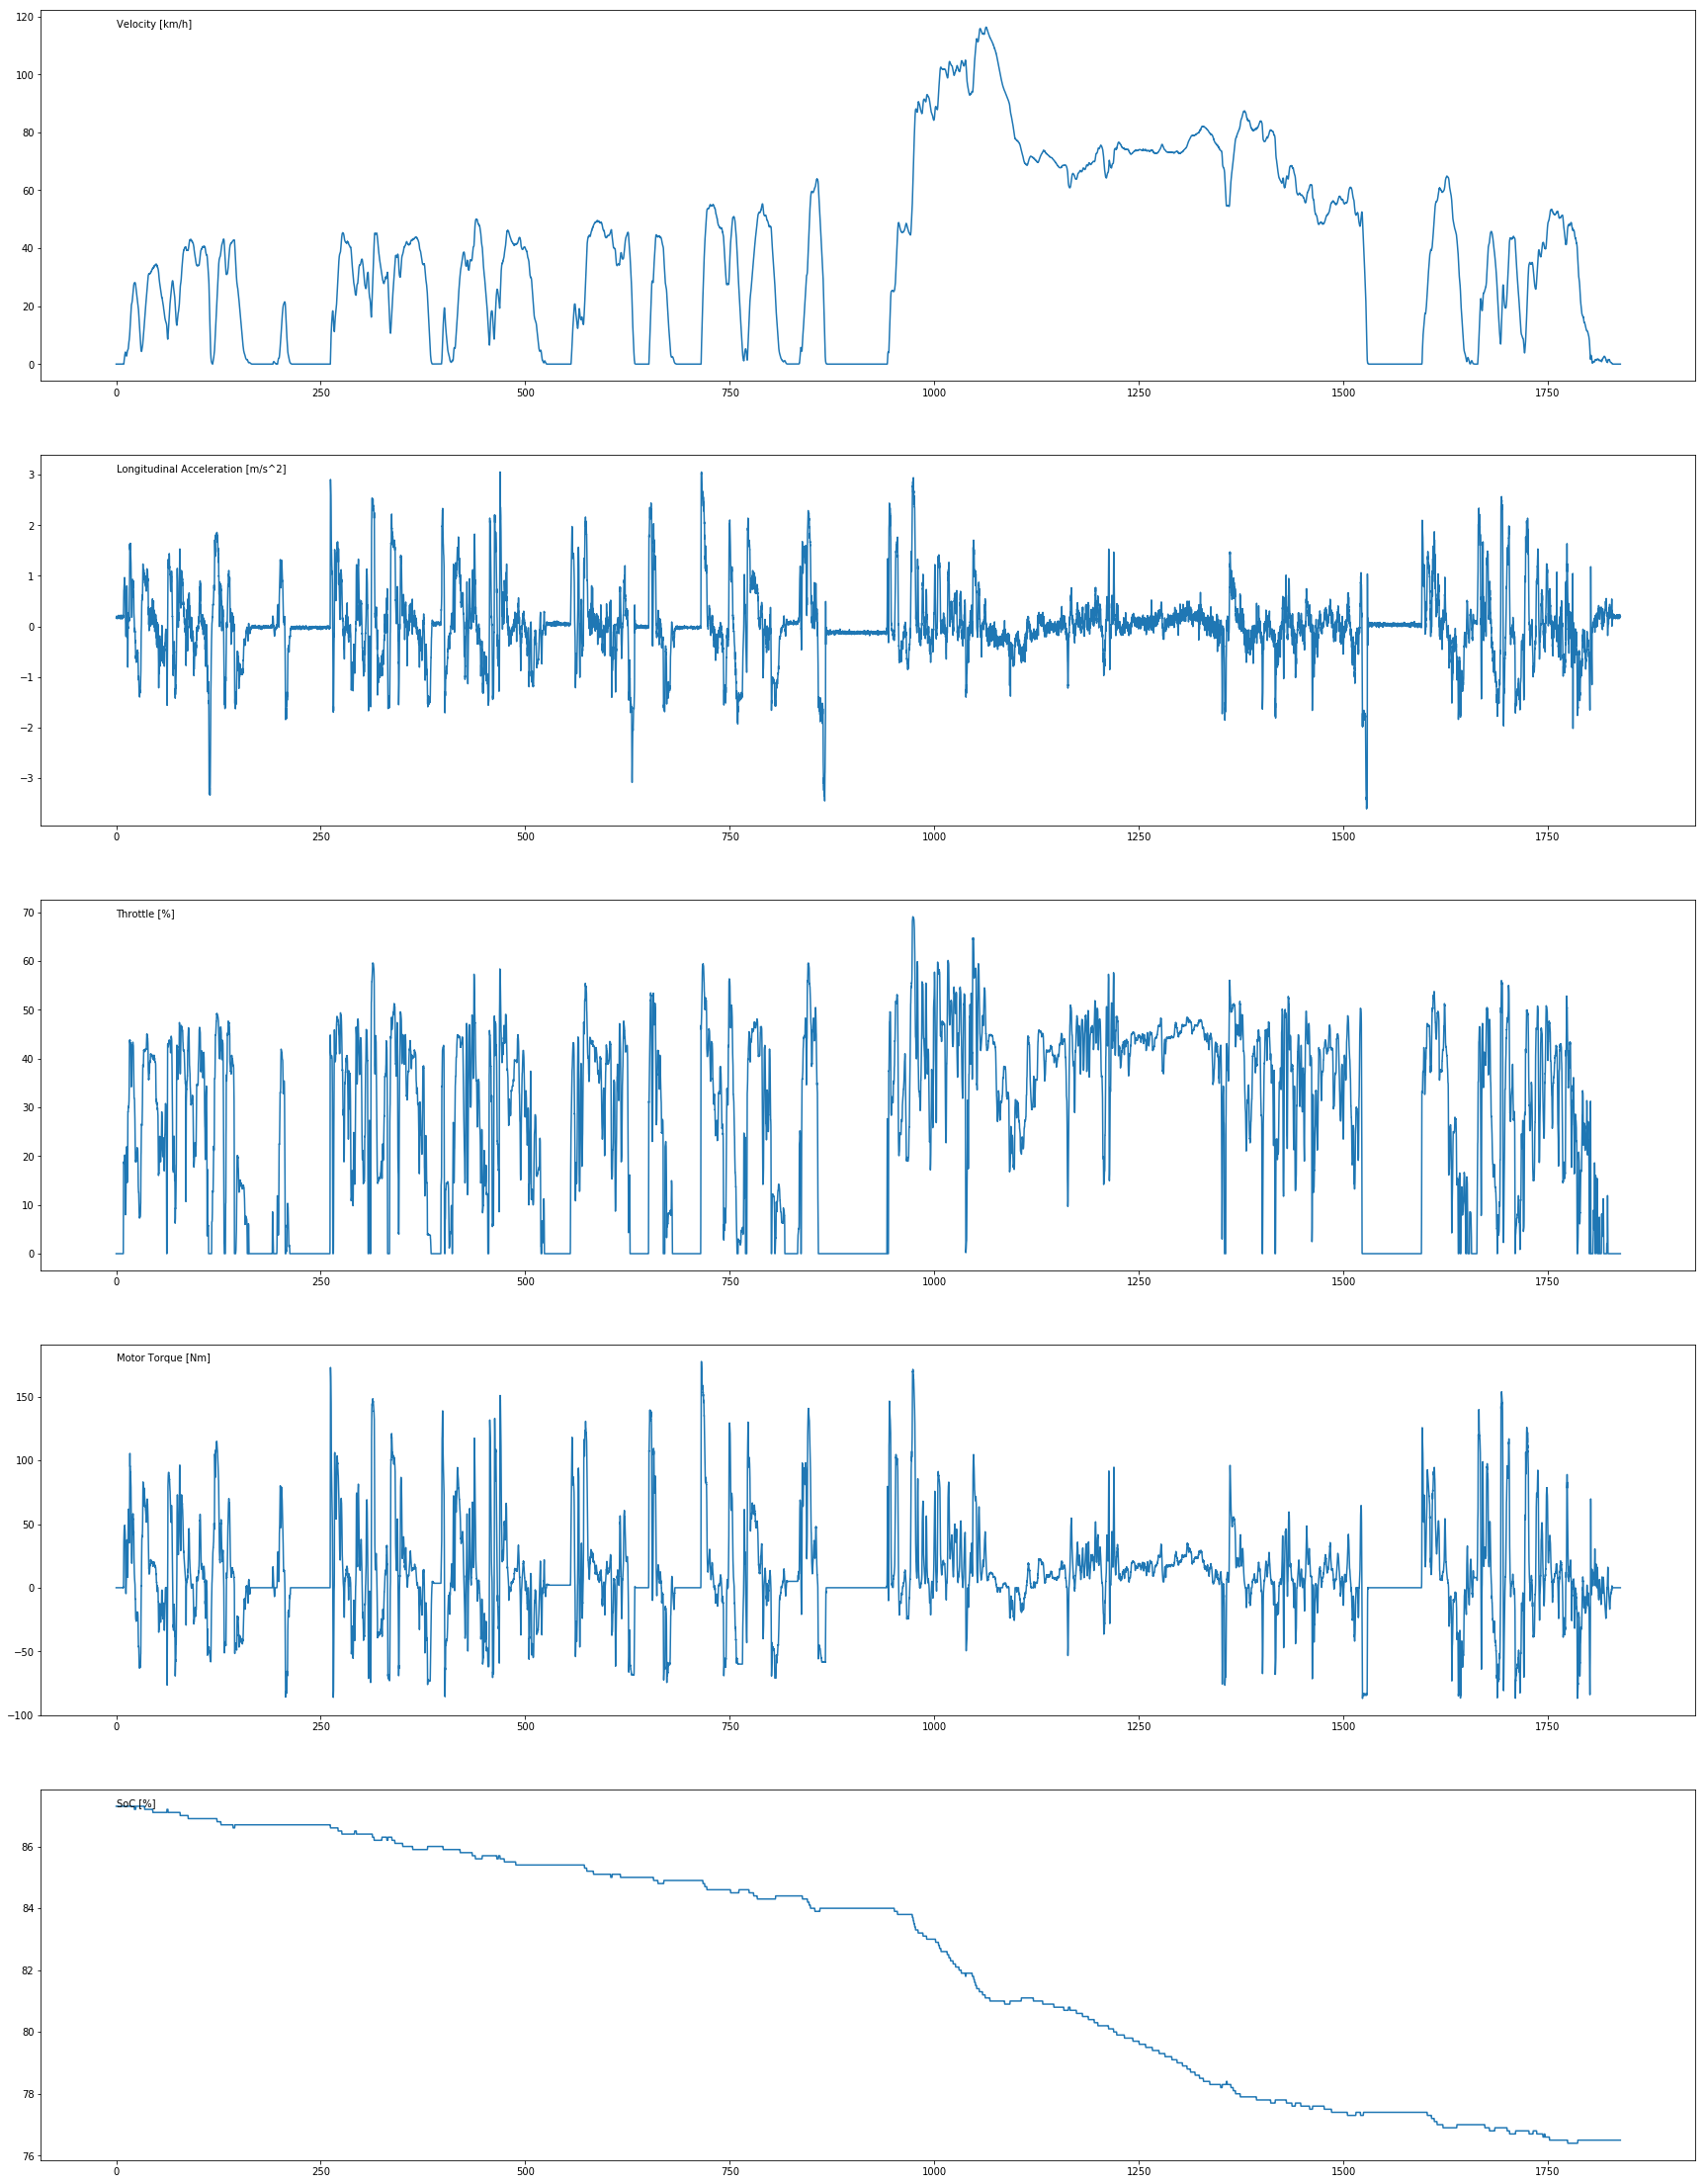

In [11]:
visualize_trip_over_time('TripA22')

Looking at exemplatory trips, we can see that the five chosen measures (Velocity, Acceleration, Throttle, Motor Torque, and State of Charge) are not independent of each other. We see certain plateaus in all diagrams, where four of the measures (Velocity, Acceleration, Throttle, Motor Torque) are zero or close to zero, and the fifth measure (State of Charge) shows no change. Presumably, this happens when the vehicle stops, e.g. at a red traffic light, an intersection, or in a traffic jam. 

In [280]:
def split_trip_into_micro_fragments(local_trip_id, plot = True):
    my_trip = trip_df[trip_df['trip_id'] == local_trip_id]
    my_trip_sorted = my_trip.sort_values(by='Time [s]').copy()
    my_trip_sorted['Micro Fragment'] = 'undefined'
    
    # Micro Fragment 1: 'stopped'
    # Definition: if the velocity is equal to 0.0 km/h the vehicle has stopped.
    
    # Micro Fragment 2: 'crusing'
    # Definition: if the velocity is constant within a range of 3 km/h, the vehicle is considered to be crusing.
    
    # Micro Fragment 3: 'accelerating' 
    # Definition: if the velocity increases by more than 10 km/h within three seconds, the vehicle is accelerating    
    
    # Micro Fragment 4: 'decelerating'
    # Definition: if the velocity decreases by more than 10 km/h within three seconds, the vehicle is decelerating
    
    crusing_threshold = 3
    accelerating_threshold = 10
    decelerating_threshold = 10

    for i in my_trip_sorted.index:
        
        #Get the velocities of the last 10 seconds
        last_velocities = []
        for r in range(-100,1,10):
            last_velocities.append(my_trip_sorted.iloc[i+r]['Velocity [km/h]'])
            
        # Check if stopping criterion is met
        is_stopped = False
        if np.max(last_velocities[-4:]) == 0:
            is_stopped = True
        if is_stopped: 
            my_trip_sorted.loc[(my_trip_sorted.index <= i) & (my_trip_sorted.index >= i-29), 'Micro Fragment'] = 'stopped'

        # Check if crusing threshold is met
        is_crusing = False
        if abs(np.max(last_velocities) - np.min(last_velocities)) < crusing_threshold:
            if last_velocities[len(last_velocities)-1] > 0:
                is_crusing = True            
        if is_crusing:
            my_trip_sorted.loc[(my_trip_sorted.index <= i) & (my_trip_sorted.index >= i-99), 'Micro Fragment'] = 'crusing'
            
        # Check if accelerating criterion is met
        is_accelerating = False
        if last_velocities[len(last_velocities)-4] < last_velocities[len(last_velocities)-3]:
            if last_velocities[len(last_velocities)-3] < last_velocities[len(last_velocities)-2]:
                if last_velocities[len(last_velocities)-2] < last_velocities[len(last_velocities)-1]:
                    if (last_velocities[len(last_velocities)-1] - last_velocities[len(last_velocities)-4]) > accelerating_threshold:
                        is_accelerating = True
        if is_accelerating:
            my_trip_sorted.loc[(my_trip_sorted.index <= i) & (my_trip_sorted.index >= i-29), 'Micro Fragment'] = 'accelerating'
            
            
        # Check if decelerating criterion is met
        is_decelerating = False
        if last_velocities[len(last_velocities)-4] > last_velocities[len(last_velocities)-3]:
            if last_velocities[len(last_velocities)-3] > last_velocities[len(last_velocities)-2]:
                if last_velocities[len(last_velocities)-2] > last_velocities[len(last_velocities)-1]:
                    if (last_velocities[len(last_velocities)-4] - last_velocities[len(last_velocities)-1]) > decelerating_threshold:
                        is_decelerating = True
        if is_decelerating:
            my_trip_sorted.loc[(my_trip_sorted.index <= i) & (my_trip_sorted.index >= i-29), 'Micro Fragment'] = 'decelerating'
            
    if plot:
        # Setting plot parameters
        plt.rcParams['figure.figsize'] = [70, 10]
        f, (vel_ax, ax) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]})

        # Plotting trip velocity
        vel_ax.plot(my_trip_sorted['Time [s]'], my_trip_sorted['Velocity [km/h]'], color = 'black')

        # Plotting micro fragments of the trip
        ax.plot(my_trip_sorted['Time [s]'], my_trip_sorted['Velocity [km/h]'], color = 'black')
        ax.fill_between(my_trip_sorted['Time [s]'], 0, 1, where= my_trip_sorted['Micro Fragment'] == 'stopped',
                        color='grey', alpha=0.5, transform=ax.get_xaxis_transform())

        ax.fill_between(my_trip_sorted['Time [s]'], 0, 1, where= my_trip_sorted['Micro Fragment'] == 'crusing',
                        color='blue', alpha=0.5, transform=ax.get_xaxis_transform())

        ax.fill_between(my_trip_sorted['Time [s]'], 0, 1, where= my_trip_sorted['Micro Fragment'] == 'accelerating',
                        color='red', alpha=0.5, transform=ax.get_xaxis_transform())

        ax.fill_between(my_trip_sorted['Time [s]'], 0, 1, where= my_trip_sorted['Micro Fragment'] == 'decelerating',
                        color='green', alpha=0.5, transform=ax.get_xaxis_transform())
        plt.show()
        
    return my_trip_sorted

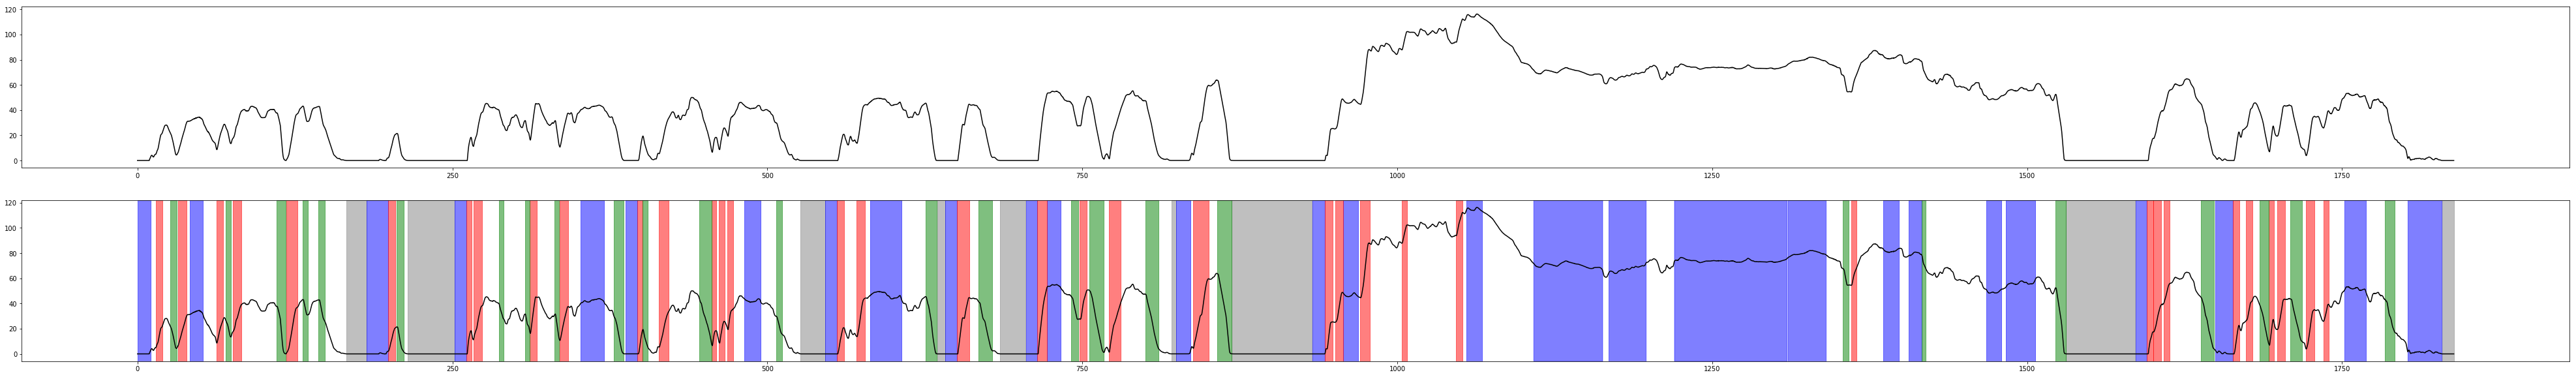

In [281]:
my_tripa22 = split_trip_into_micro_fragments('TripA22')

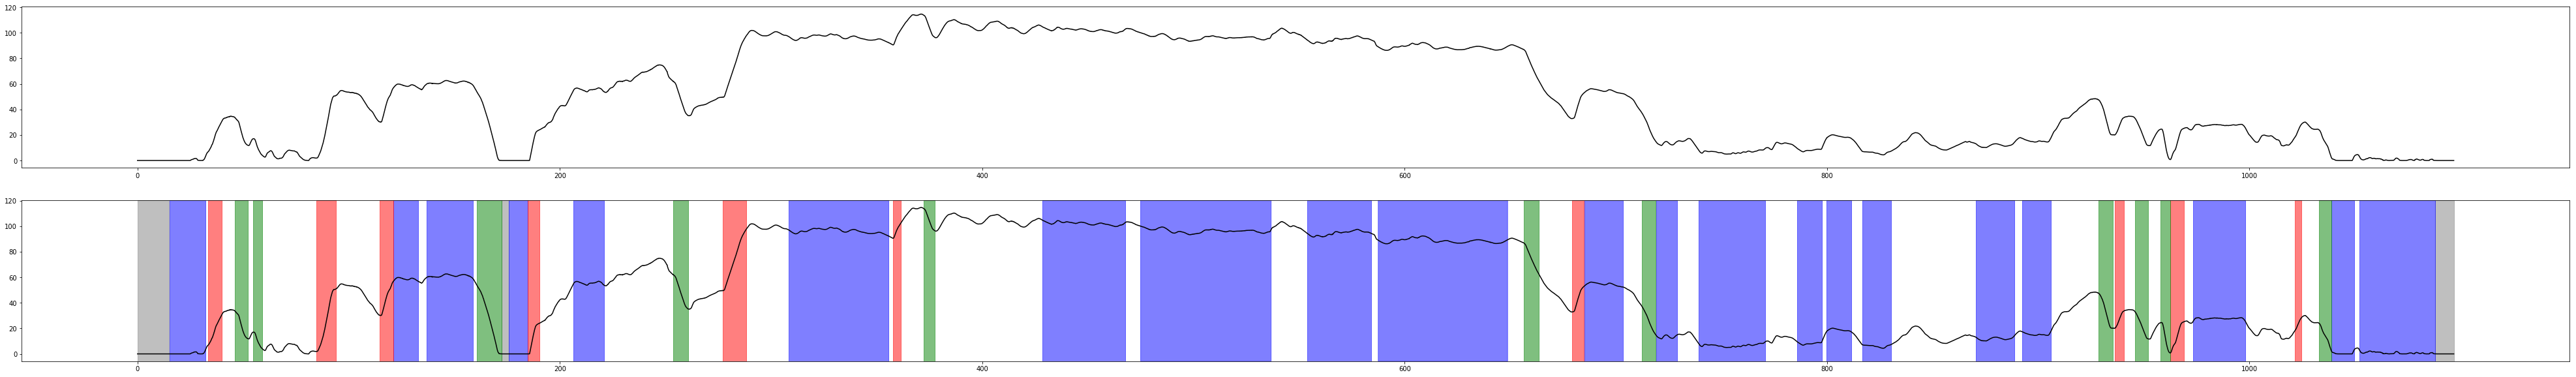

In [282]:
my_tripb31 = split_trip_into_micro_fragments('TripB31')

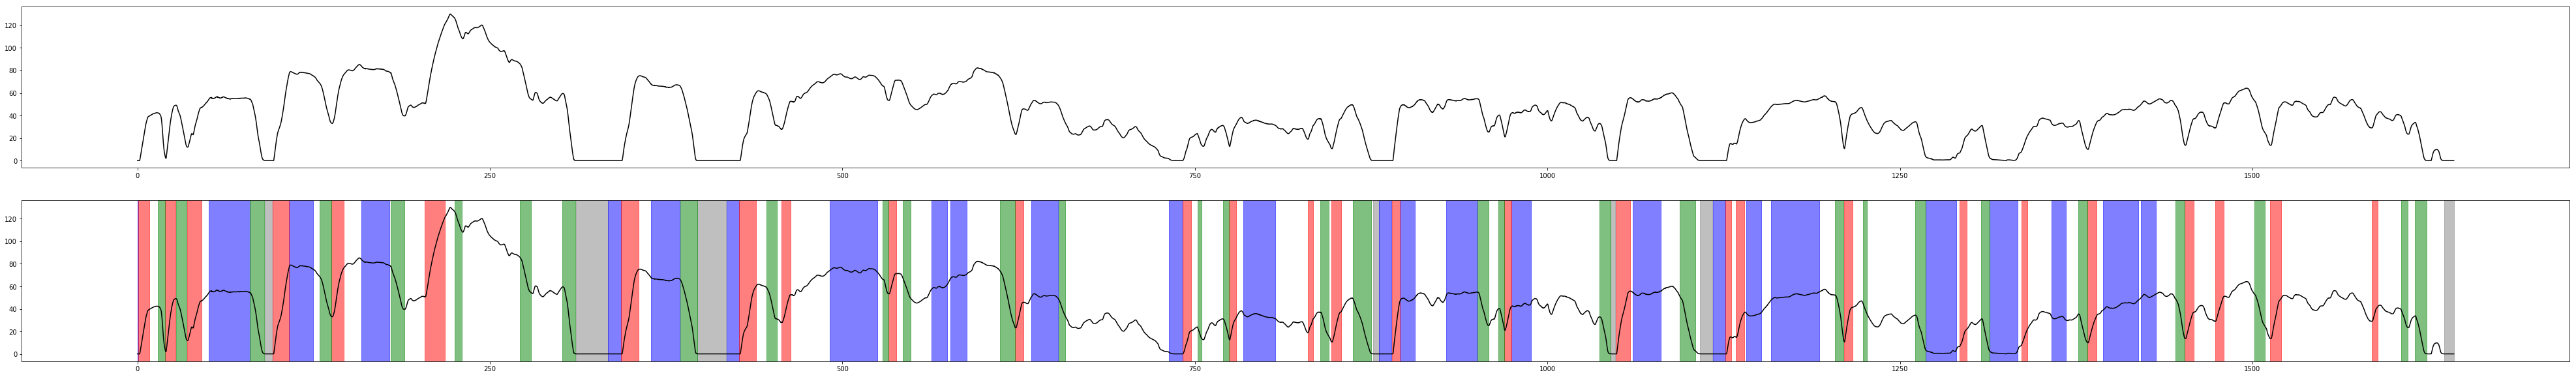

In [283]:
my_tripb38 = split_trip_into_micro_fragments('TripB38')

In [51]:
## Recognize all stopping events within a trip
my_trip_id = 'TripA22'
my_trip = trip_df[trip_df['trip_id'] == my_trip_id]

my_trip_sorted = my_trip.sort_values(by='Time [s]').copy()

In [239]:
my_trip_sorted['Micro Fragment'] = 'undefined'

In [53]:
my_trip_sorted.head()

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,Temperature Footweel Co-Driver [°C],Temperature Feetvent Co-Driver [°C],Temperature Feetvent Driver [°C],Temperature Head Co-Driver [°C],Temperature Head Driver [°C],Temperature Vent Two [°C],Temperature Vent central right [°C],Temperature Vent central left [°C],Temperature Vent One [°C],Micro Fragment
0,0.0,0.0,523.0,0.0,0.0,0.17200,0.0,392.50000,-1.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,undefined
1,0.1,0.0,523.0,0.0,0.0,0.17881,0.0,392.50000,-1.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,undefined
2,0.2,0.0,523.0,0.0,0.0,0.17838,0.0,392.48213,-1.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,undefined
3,0.3,0.0,523.0,0.0,0.0,0.15881,0.0,392.43211,-1.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,undefined
4,0.4,0.0,523.0,0.0,0.0,0.17200,0.0,392.40000,-1.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,undefined


In [32]:
my_trip_sorted.shape

(18388, 49)

In [240]:
# Micro Fragment 1: 'stopped'
# Definition: if the velocity is equal to 0.0 km/h the vehicle has stopped.

my_trip_sorted.loc[my_trip_sorted['Velocity [km/h]'] == 0.0, 'Micro Fragment'] = 'stopped'

## ToDo: stopping needs to last three (?) seconds.
## ToDo: how to handle brief stop interruptions, e.g. "roll forward" at a traffic light / intersection with less than X km/h


In [141]:
#my_trip_sorted[my_trip_sorted['Time [s]'] > 195].head(n=100)
## short stop of ~ 1 second, e.g. at 196s

In [ ]:
# Micro Fragment 2: 'crusing'
# Defintion: if the velocity is constant within a range of 3 km/h, the vehicle is considered to be crusing.

# ToDo: Crusing phase needs to last at least XXXXX seconds.
# To Check: can other factors be considered? Motor Torque, Elevation, Throttle below a certain percentage??

In [241]:
# If the velocity is constant within a range of 3 km/h, we consider the vehicle to be 'crusing'
crusing_threshold = 3

for i in my_trip_sorted.index:
    #Get the velocities of the last 10 seconds
    last_velocities = []
    for r in range(-100,1,10):
        last_velocities.append(my_trip_sorted.iloc[i+r]['Velocity [km/h]'])

    # Check if crusing threshold is met
    is_crusing = False
    if abs(np.max(last_velocities) - np.min(last_velocities)) < crusing_threshold:
        if last_velocities[len(last_velocities)-1] > 0:
            is_crusing = True
    
    #if abs(np.max(last_velocities) - np.min(last_velocities)) < crusing_threshold and last_velocities[len(last_velocities)-1] > 1:
    if is_crusing:
        my_trip_sorted.loc[(my_trip_sorted.index <= i) & (my_trip_sorted.index >= i-99), 'Micro Fragment'] = 'crusing'

In [ ]:
# Micro Fragment 3 and Micro Fragment 4: 'accelerating' and 'decelerating'
# Definition: if the velocity increases by more than 10 km/h within three seconds, the vehicle is accelerating
# Definition: if the velocity decreases by more than 10 km/h within three seconds, the vehicle is decelerating

# ToDo: Acceleration / Deceleration phase needs to last at least XXXXX seconds.
# To Check: can other factors be considered? Motor Torque, Throttle above a certain percentage, Acceleration, Braking??

In [242]:
# If the velocity increases by more than 10 km/h within three seconds, we consider the vehicle to be 'accelerating'
accelerating_threshold = 10
decelerating_threshold = 10

for i in my_trip_sorted.index:
    #Get the velocities of the last three seconds
    last_velocities = [my_trip_sorted.iloc[i-29]['Velocity [km/h]'],
                       my_trip_sorted.iloc[i-19]['Velocity [km/h]'],
                       my_trip_sorted.iloc[i-9]['Velocity [km/h]'],
                       my_trip_sorted.iloc[i]['Velocity [km/h]']]

    # Check if accelerating criterion is met
    is_accelerating = False
    if last_velocities[0] < last_velocities[1]:
        if last_velocities[1] < last_velocities[2]:
            if last_velocities[2] < last_velocities[3]:
                if (last_velocities[3] - last_velocities[0]) > accelerating_threshold:
                    is_accelerating = True
    
    if is_accelerating:
        my_trip_sorted.loc[(my_trip_sorted.index <= i) & (my_trip_sorted.index >= i-29), 'Micro Fragment'] = 'accelerating'
        
        
    # Check if decelerating criterion is met
    is_decelerating = False
    if last_velocities[0] > last_velocities[1]:
        if last_velocities[1] > last_velocities[2]:
            if last_velocities[2] > last_velocities[3]:
                if (last_velocities[0] - last_velocities[3]) > decelerating_threshold:
                    is_decelerating = True
    
    if is_decelerating:
        my_trip_sorted.loc[(my_trip_sorted.index <= i) & (my_trip_sorted.index >= i-29), 'Micro Fragment'] = 'decelerating'

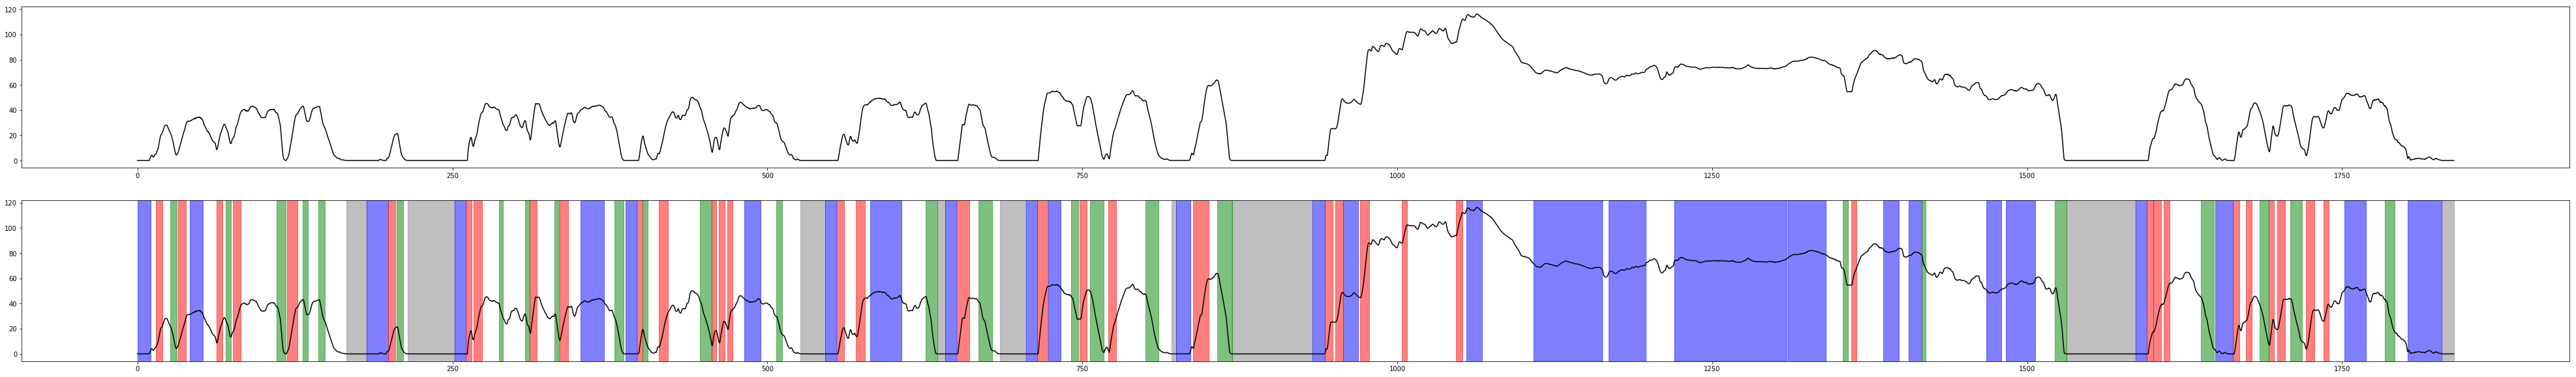

In [271]:
# Setting plot parameters
#plt.rcParams['figure.figsize'] = [25, 10]
#f, (vel_ax, ax) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 3]})

plt.rcParams['figure.figsize'] = [70, 10]
f, (vel_ax, ax) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 1]})

# Plotting trip velocity
vel_ax.plot(my_trip_sorted['Time [s]'], my_trip_sorted['Velocity [km/h]'], color = 'black')

# Plotting micro fragments of the trip
ax.plot(my_trip_sorted['Time [s]'], my_trip_sorted['Velocity [km/h]'], color = 'black')
ax.fill_between(my_trip_sorted['Time [s]'], 0, 1, where= my_trip_sorted['Micro Fragment'] == 'stopped',
                color='grey', alpha=0.5, transform=ax.get_xaxis_transform())

ax.fill_between(my_trip_sorted['Time [s]'], 0, 1, where= my_trip_sorted['Micro Fragment'] == 'crusing',
                color='blue', alpha=0.5, transform=ax.get_xaxis_transform())

ax.fill_between(my_trip_sorted['Time [s]'], 0, 1, where= my_trip_sorted['Micro Fragment'] == 'accelerating',
                color='red', alpha=0.5, transform=ax.get_xaxis_transform())

ax.fill_between(my_trip_sorted['Time [s]'], 0, 1, where= my_trip_sorted['Micro Fragment'] == 'decelerating',
                color='green', alpha=0.5, transform=ax.get_xaxis_transform())


plt.show()

In [223]:
my_trip_sorted['Micro Fragment'].value_counts()

undefined       11065
stopped          3276
accelerating     2251
decelerating     1796
Name: Micro Fragment, dtype: int64

In [194]:
my_trip_sorted.head(n=200)

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,Temperature Feetvent Co-Driver [°C],Temperature Feetvent Driver [°C],Temperature Head Co-Driver [°C],Temperature Head Driver [°C],Temperature Vent Two [°C],Temperature Vent central right [°C],Temperature Vent central left [°C],Temperature Vent One [°C],Micro Fragment,Previous Velocity [km/h]
0,0.0,0.00000,523.0,0.00000,0.00000,0.17200,0.0,392.50000,-1.00000,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stopped,0.00000
1,0.1,0.00000,523.0,0.00000,0.00000,0.17881,0.0,392.50000,-1.00000,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stopped,0.00000
2,0.2,0.00000,523.0,0.00000,0.00000,0.17838,0.0,392.48213,-1.00000,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stopped,0.00000
3,0.3,0.00000,523.0,0.00000,0.00000,0.15881,0.0,392.43211,-1.00000,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stopped,0.00000
4,0.4,0.00000,523.0,0.00000,0.00000,0.17200,0.0,392.40000,-1.00000,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stopped,0.00000
5,0.5,0.00000,523.0,0.00000,0.00000,0.18562,0.0,392.40000,-1.00000,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stopped,0.00000
6,0.6,0.00000,523.0,0.00000,0.00000,0.20519,0.0,392.40000,-1.00000,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stopped,0.00000
7,0.7,0.00000,523.0,0.00000,0.00000,0.19881,0.0,392.40000,-1.00000,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stopped,0.00000
8,0.8,0.00000,523.0,0.00000,0.00000,0.19838,0.0,392.40000,-1.00000,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stopped,0.00000
9,0.9,0.00000,523.0,0.00000,0.00000,0.17200,0.0,392.40000,-1.00000,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,stopped,0.00000


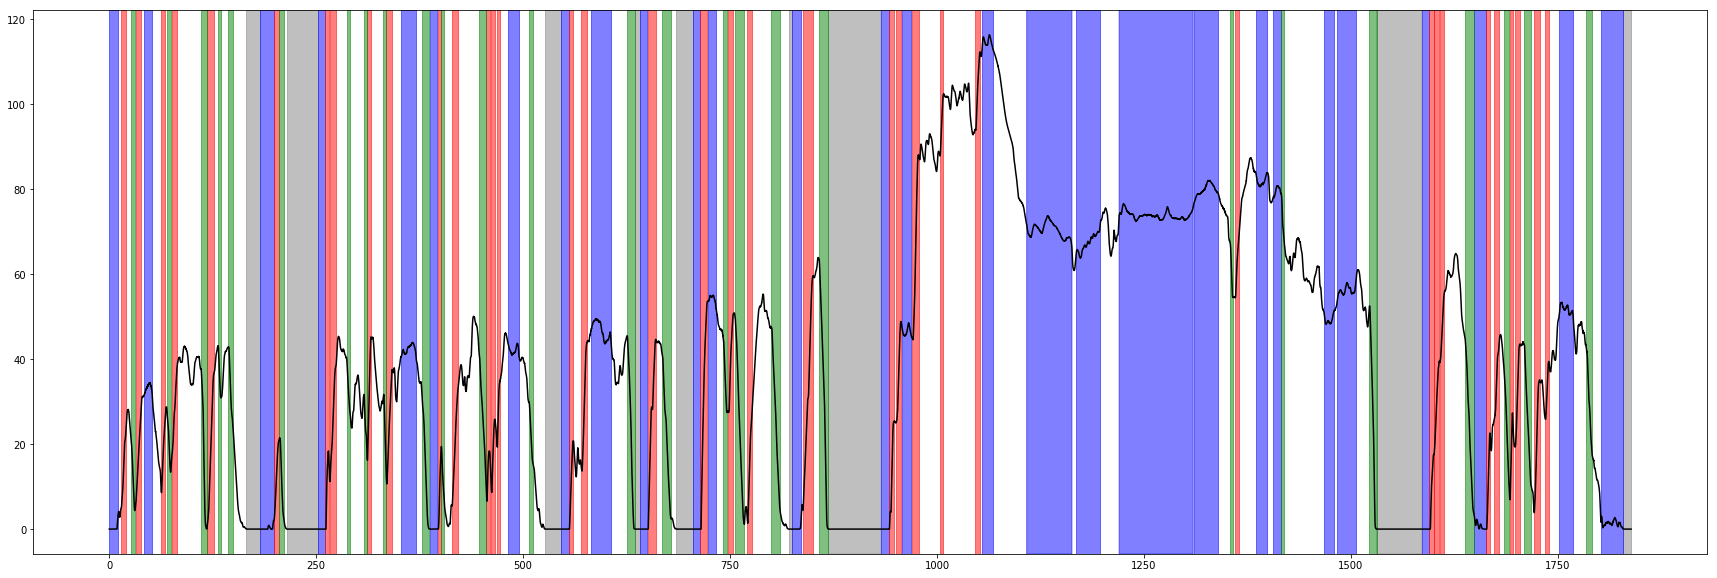

In [247]:
## Plotting trip velocity
plt.rcParams['figure.figsize'] = [30, 10]

fig, ax = plt.subplots()
ax.plot(my_trip_sorted['Time [s]'], my_trip_sorted['Velocity [km/h]'], color = 'black')

## Plotting micro fragments of trip
ax.fill_between(my_trip_sorted['Time [s]'], 0, 1, where= my_trip_sorted['Micro Fragment'] == 'stopped',
                color='grey', alpha=0.5, transform=ax.get_xaxis_transform())

ax.fill_between(my_trip_sorted['Time [s]'], 0, 1, where= my_trip_sorted['Micro Fragment'] == 'crusing',
                color='blue', alpha=0.5, transform=ax.get_xaxis_transform())

ax.fill_between(my_trip_sorted['Time [s]'], 0, 1, where= my_trip_sorted['Micro Fragment'] == 'accelerating',
                color='red', alpha=0.5, transform=ax.get_xaxis_transform())

ax.fill_between(my_trip_sorted['Time [s]'], 0, 1, where= my_trip_sorted['Micro Fragment'] == 'decelerating',
                color='green', alpha=0.5, transform=ax.get_xaxis_transform())

#Hilfslinie
#ax.plot([1250,1250,1250],[0,50,120])
#ax.plot([1259,1259,1259],[0,50,120])

plt.show()

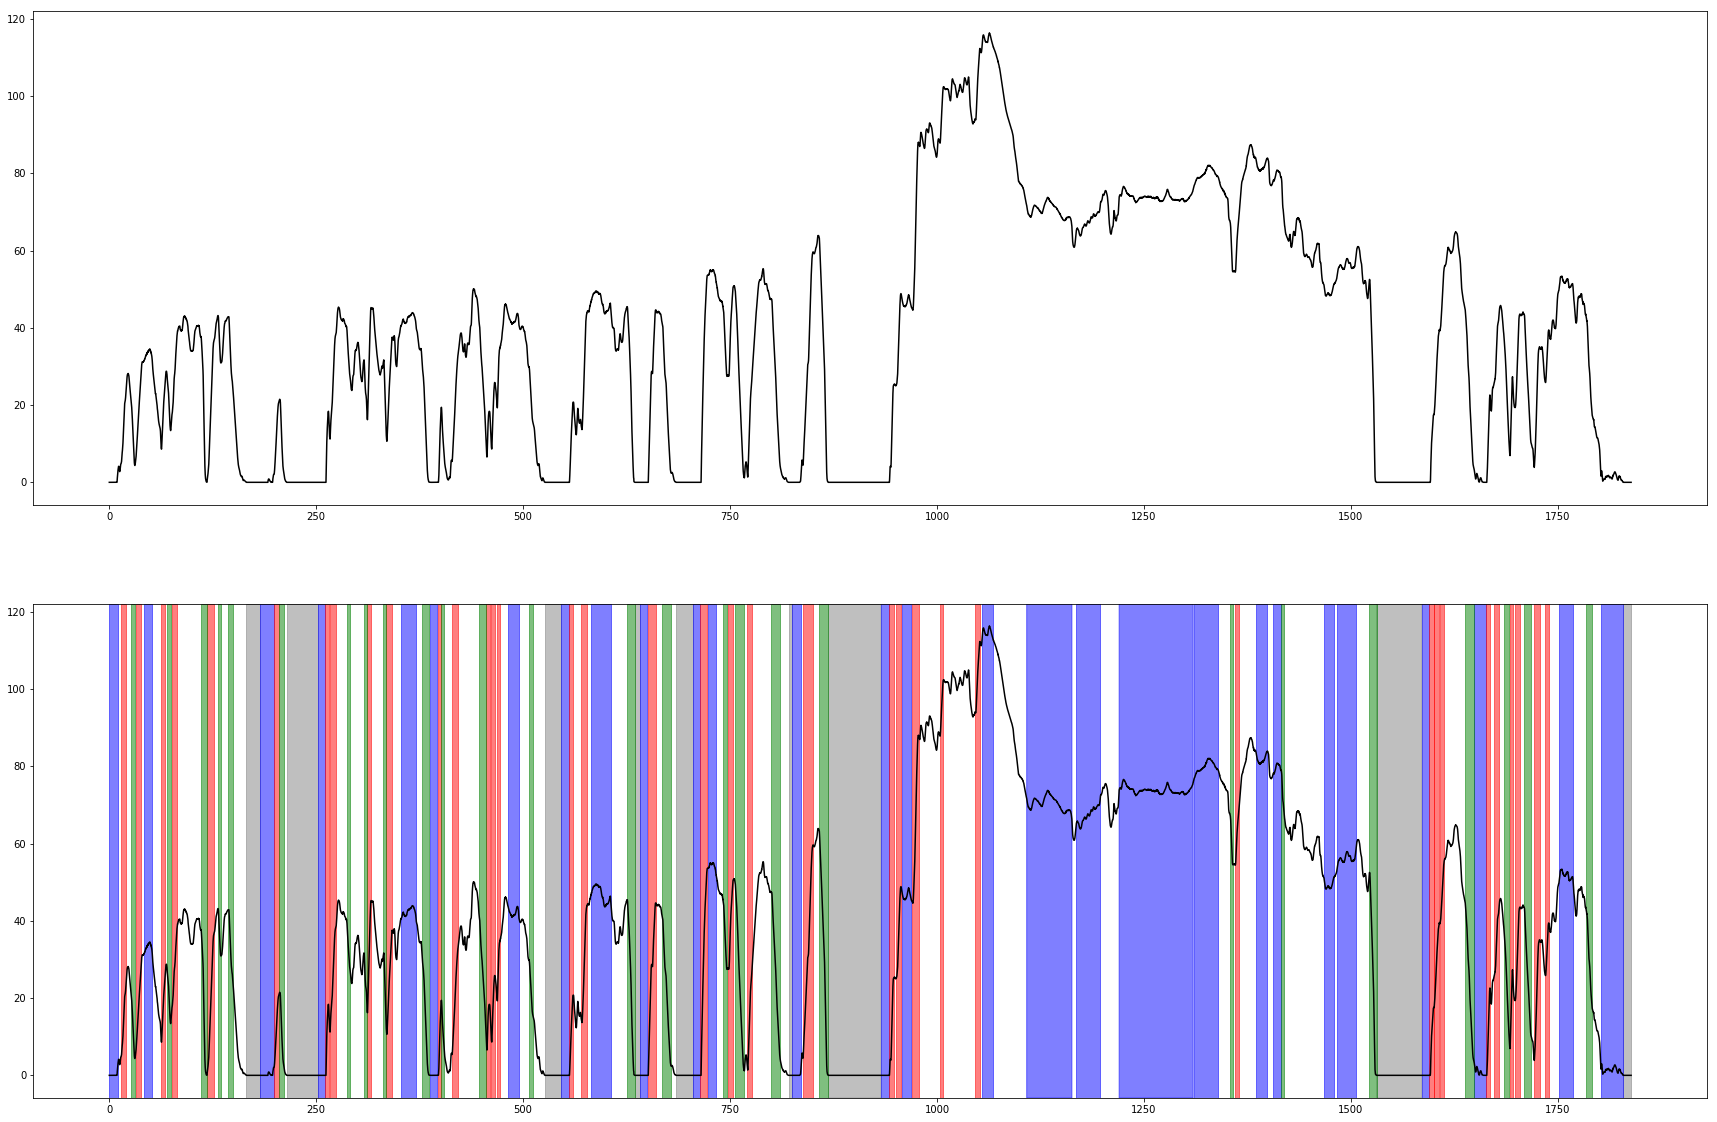

In [257]:
plt.rcParams['figure.figsize'] = [30, 20]
gs = grd.GridSpec(2, 1)

vel_ax = plt.subplot(gs[0])
vel_ax.plot(my_trip_sorted['Time [s]'], my_trip_sorted['Velocity [km/h]'], color = 'black')

ax = plt.subplot(gs[1])
ax.plot(my_trip_sorted['Time [s]'], my_trip_sorted['Velocity [km/h]'], color = 'black')
ax.fill_between(my_trip_sorted['Time [s]'], 0, 1, where= my_trip_sorted['Micro Fragment'] == 'stopped',
                color='grey', alpha=0.5, transform=ax.get_xaxis_transform())

ax.fill_between(my_trip_sorted['Time [s]'], 0, 1, where= my_trip_sorted['Micro Fragment'] == 'crusing',
                color='blue', alpha=0.5, transform=ax.get_xaxis_transform())

ax.fill_between(my_trip_sorted['Time [s]'], 0, 1, where= my_trip_sorted['Micro Fragment'] == 'accelerating',
                color='red', alpha=0.5, transform=ax.get_xaxis_transform())

ax.fill_between(my_trip_sorted['Time [s]'], 0, 1, where= my_trip_sorted['Micro Fragment'] == 'decelerating',
                color='green', alpha=0.5, transform=ax.get_xaxis_transform())


plt.show()

Moving on to the trip overview dataset, we find two empty rows and one empty column which will be deleted.

In [12]:
# Exploring the NaN values in trip_overview shows that two rows are empty. They are removed.
print((trip_overview.isna().sum(axis=1)/trip_overview.shape[1]).sort_values(ascending=False)[0:10])
trip_overview.dropna(subset=['Trip'], inplace=True)

# Further explorations show that the column 'Unnamed: 13' contains only NaN values. It is removed.
print((trip_overview.isna().sum()/trip_overview.shape[0]).sort_values(ascending=False))
trip_overview.drop(columns=['Unnamed: 13'], inplace=True)
trip_overview.rename(columns={'Unnamed: 8': 'Battery State of Charge (Difference)'}, inplace=True)

33    1.000
32    1.000
35    0.125
70    0.125
31    0.125
30    0.125
29    0.125
28    0.125
27    0.125
26    0.125
dtype: float64
Unnamed: 13                         1.000000
Note                                0.628571
Fan                                 0.000000
Duration [min]                      0.000000
Distance [km]                       0.000000
Target Cabin Temperature            0.000000
Ambient Temperature (Start) [°C]    0.000000
Unnamed: 8                          0.000000
Battery State of Charge (End)       0.000000
Battery State of Charge (Start)     0.000000
Battery Temperature (End)           0.000000
Battery Temperature (Start) [°C]    0.000000
Weather                             0.000000
Route/Area                          0.000000
Date                                0.000000
Trip                                0.000000
dtype: float64


Additionally, there are two trips with a negative state of charge difference between start and end of trip; as well as one trip with a wrongly calculated State of Charge difference. These findings are cleaned up.

In [13]:
# Trips with negative State of Charge difference between start and end of trip
print('Number of trips with negative state of charge difference: ', 
      len(trip_overview[trip_overview['Battery State of Charge (Start)'] < trip_overview['Battery State of Charge (End)']]))

# Trips where the difference column does not match the difference between start and end of trip
print('Number of trips with a wrongly calculated difference in state of charge: ', 
      len(trip_overview[trip_overview['Battery State of Charge (Start)'] - trip_overview['Battery State of Charge (End)'] != trip_overview['Battery State of Charge (Difference)']]))

# Ensure that 'Battery State of Charge (Start)' - 'Battery State of Chager (End) == 'Battery State of Charge (Difference)'
# Remove rows with a negative State of Charge difference
trip_overview['Battery State of Charge (Difference)'] = trip_overview['Battery State of Charge (Start)'] - trip_overview['Battery State of Charge (End)']
trip_overview.drop(trip_overview[trip_overview['Battery State of Charge (Start)'] < trip_overview['Battery State of Charge (End)']].index, inplace=True)

Number of trips with negative state of charge difference:  2
Number of trips with a wrongly calculated difference in state of charge:  1


In [14]:
trip_overview.head()

,Trip,Date,Route/Area,Weather,Battery Temperature (Start) [°C],Battery Temperature (End),Battery State of Charge (Start),Battery State of Charge (End),Battery State of Charge (Difference),Ambient Temperature (Start) [°C],Target Cabin Temperature,Distance [km],Duration [min],Fan,Note
0,TripA01,2019-06-25_13-21-14,Munich East,sunny,21.0,22.0,0.863,0.803,0.060,25.5,23.0,7.427690,16.820000,"Automatic, Level 1",NaN
1,TripA02,2019-06-25_14-05-31,Munich East,sunny,23.0,26.0,0.803,0.673,0.130,32.0,23.0,23.509709,23.550000,"Automatic, Level 1",Target Cabin Temperature changed
2,TripA03,2019-06-28_10-02-15,Munich East,sunny,24.0,25.0,0.835,0.751,0.084,21.5,27.0,12.820846,11.180000,"Automatic, Level 1",Target Cabin Temperature changed
3,TripA04,2019-06-28_10-13-30,Munich East,sunny,25.0,27.0,0.751,0.667,0.084,24.0,22.0,10.727491,6.870000,"Automatic, Level 1",NaN
4,TripA05,2019-06-28_10-20-26,Munich East,sunny,27.0,27.0,0.667,0.602,0.065,24.5,24.0,12.393223,22.776667,"Automatic, Level 1",NaN


The following visualisation shows a first approach to see the correlation between temperature and state of charge.

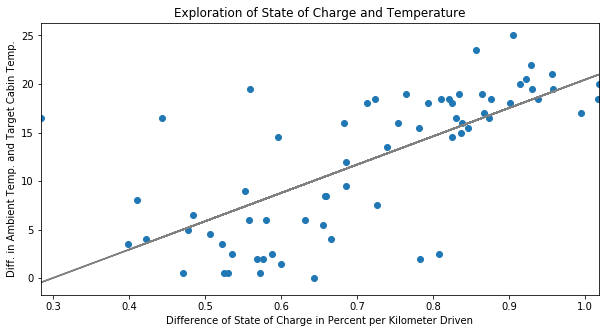

In [29]:
plt.rcParams['figure.figsize'] = [10, 5]

# Scatterplot
x = trip_overview['Battery State of Charge (Difference)'] * 100 / trip_overview['Distance [km]']
y = abs(trip_overview['Ambient Temperature (Start) [°C]'] - trip_overview['Target Cabin Temperature'])
plt.scatter(x, y)

# Linear regression line
m, c = np.polyfit(x, y, 1)
plt.plot(x, m*x+c, color='grey')

# Labeling plot
plt.xlim(x.min(), x.max())
plt.xlabel('Difference of State of Charge in Percent per Kilometer Driven')
plt.ylabel('Diff. in Ambient Temp. and Target Cabin Temp.')
plt.title('Exploration of State of Charge and Temperature')

plt.show()

Next, we are merging trip_df and trip_overview data frames into one dataframe named trip_infos.

In [16]:
# Merging trip_df and trip_overview on trip_id
trip_overview.rename(columns={'Trip': 'trip_id'}, inplace=True)
trip_infos = pd.merge(left=trip_df, right=trip_overview, on='trip_id')
trip_infos.sort_values(['trip_id', 'Time [s]'], inplace=True)
trip_infos.head()

,Time [s],Velocity [km/h],Elevation [m],Throttle [%],Motor Torque [Nm],Longitudinal Acceleration [m/s^2],Regenerative Braking Signal,Battery Voltage [V],Battery Current [A],Battery Temperature [°C],...,Battery Temperature (End),Battery State of Charge (Start),Battery State of Charge (End),Battery State of Charge (Difference),Ambient Temperature (Start) [°C],Target Cabin Temperature,Distance [km],Duration [min],Fan,Note
0,0.0,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.20,21.0,...,22.0,0.863,0.803,0.06,25.5,23.0,7.42769,16.82,"Automatic, Level 1",NaN
1,0.1,0.0,574.0,0.0,0.0,0.00,0.0,391.4,-2.21,21.0,...,22.0,0.863,0.803,0.06,25.5,23.0,7.42769,16.82,"Automatic, Level 1",NaN
2,0.2,0.0,574.0,0.0,0.0,-0.01,0.0,391.4,-2.26,21.0,...,22.0,0.863,0.803,0.06,25.5,23.0,7.42769,16.82,"Automatic, Level 1",NaN
3,0.3,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.30,21.0,...,22.0,0.863,0.803,0.06,25.5,23.0,7.42769,16.82,"Automatic, Level 1",NaN
4,0.4,0.0,574.0,0.0,0.0,-0.03,0.0,391.4,-2.30,21.0,...,22.0,0.863,0.803,0.06,25.5,23.0,7.42769,16.82,"Automatic, Level 1",NaN


The following visualisation shows boxplots of the motor torque for all trips. We can see that the mean as well as the quantiles differ between trips.

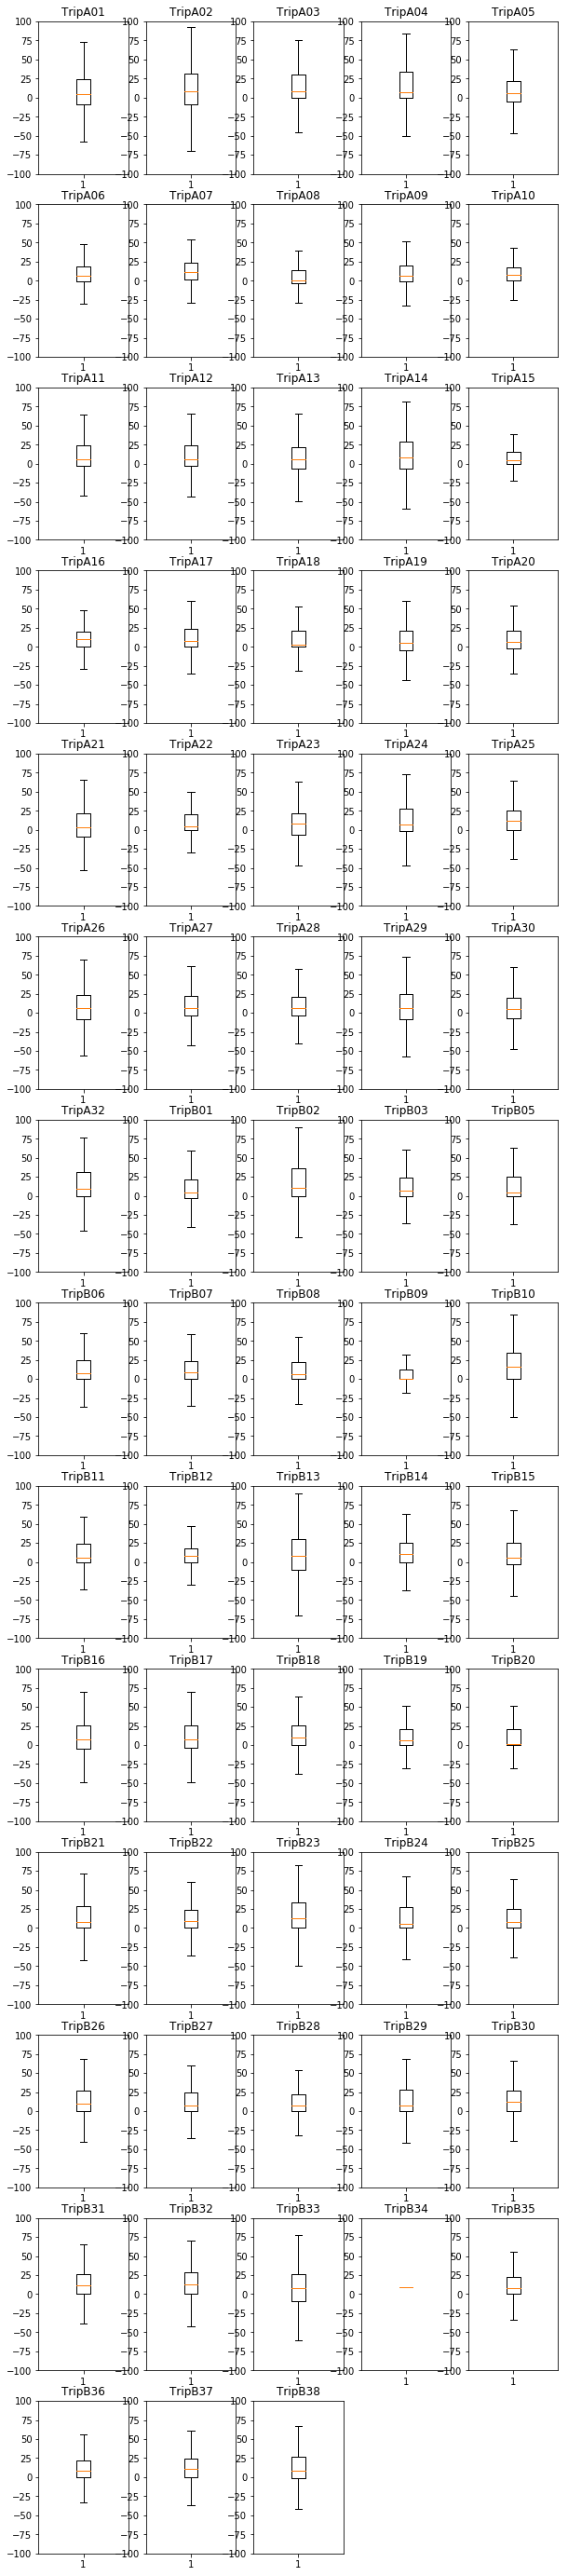

In [17]:
# Visualizing Motor Torque within individual trips
plt.rcParams['figure.figsize'] = [10, 50]
gs = grd.GridSpec(14, 5)

unique_trip_ids = trip_infos['trip_id'].unique()
for i in range(0, len(unique_trip_ids)):
    this_trip = trip_infos[trip_infos['trip_id'] == unique_trip_ids[i]]
    
    this_ax = plt.subplot(gs[i])
    this_ax.set_title(unique_trip_ids[i])
    this_ax.boxplot(this_trip['Motor Torque [Nm]'], showfliers=False)
    this_ax.set_ylim(-100, 100)

plt.show()

# Step 3 | Data Preparation

We are now transforming and preparing our trip_infos data frame for the upcoming modeling. We choose independent features as well as a target variable, ensure that all columns are meaningful and check that the data types are suitable for modeling.

As independent variables we choose:
- Statistic values on the use of throttle and the motor torque
- Power used for Air Conditioning and/or Heating
- Ambient temperture, start temperature of the battery, and start State of Charge of the battery
- Statistic values on the acceleration and deceleration of the vehicle
- The change in elevation
- Distance and duration of the trip

Our target variable is
- Difference in State of Charge (in Percent)

In [18]:
# Creating data frame for modeling
all_variables = []
unique_trip_ids = trip_infos['trip_id'].unique()
for i in range(0, len(unique_trip_ids)):
    #print('Calculating ', unique_trip_ids[i])
    
    this_trip_id = unique_trip_ids[i]
    this_trip = trip_infos[trip_infos['trip_id'] == this_trip_id]
    
    # Calculating statistics of throttle and torque
    throttle_mean = this_trip['Throttle [%]'].mean()
    throttle_25 = this_trip['Throttle [%]'].describe()[4]
    throttle_50 = this_trip['Throttle [%]'].describe()[5]
    throttle_75 = this_trip['Throttle [%]'].describe()[6]
    
    torque_mean = this_trip['Motor Torque [Nm]'].mean()
    torque_25 = this_trip['Motor Torque [Nm]'].describe()[4]
    torque_50 = this_trip['Motor Torque [Nm]'].describe()[5]
    torque_75 = this_trip['Motor Torque [Nm]'].describe()[6]
    
    # Power for Air Condition and Heating
    aircon_heat_mean = (this_trip['AirCon Power [kW]']+this_trip['Heating Power CAN [kW]']).mean()
    aircon_heat_25 = (this_trip['AirCon Power [kW]']+this_trip['Heating Power CAN [kW]']).describe()[4]
    aircon_heat_50 = (this_trip['AirCon Power [kW]']+this_trip['Heating Power CAN [kW]']).describe()[5]
    aircon_heat_75 = (this_trip['AirCon Power [kW]']+this_trip['Heating Power CAN [kW]']).describe()[6]
        
    # Ambient Temperature
    ambient_start_temp = this_trip['Ambient Temperature (Start) [°C]'].min()
    
    # Start temperature of the battery
    battery_start_temp = this_trip['Battery Temperature (Start) [°C]'].min()
    
    # Battery State of Charge
    battery_start_soc = this_trip['Battery State of Charge (Start)'].min()
    
    # Calculating statistics for acceleration and deceleration
    acc_mean = this_trip[this_trip['Longitudinal Acceleration [m/s^2]'] > 0]['Longitudinal Acceleration [m/s^2]'].mean()
    acc_25 = this_trip[this_trip['Longitudinal Acceleration [m/s^2]'] > 0]['Longitudinal Acceleration [m/s^2]'].describe()[4]
    acc_50 = this_trip[this_trip['Longitudinal Acceleration [m/s^2]'] > 0]['Longitudinal Acceleration [m/s^2]'].describe()[5]
    acc_75 = this_trip[this_trip['Longitudinal Acceleration [m/s^2]'] > 0]['Longitudinal Acceleration [m/s^2]'].describe()[6]
    
    dec_mean = this_trip[this_trip['Longitudinal Acceleration [m/s^2]'] < 0]['Longitudinal Acceleration [m/s^2]'].mean()
    dec_25 = this_trip[this_trip['Longitudinal Acceleration [m/s^2]'] < 0]['Longitudinal Acceleration [m/s^2]'].describe()[4]
    dec_50 = this_trip[this_trip['Longitudinal Acceleration [m/s^2]'] < 0]['Longitudinal Acceleration [m/s^2]'].describe()[5]
    dec_75 = this_trip[this_trip['Longitudinal Acceleration [m/s^2]'] < 0]['Longitudinal Acceleration [m/s^2]'].describe()[6]
    
    # Calculate change in elevation
    elevation_df = this_trip[['Time [s]', 'Elevation [m]']].sort_values('Time [s]')

    all_diff_elevation = []
    last_elevation = elevation_df.iloc[0]['Elevation [m]']
    for e, row in elevation_df.iterrows():
        this_elevation = row['Elevation [m]']
        diff_elevation = this_elevation - last_elevation
        all_diff_elevation.append(diff_elevation)
        last_elevation = this_elevation    
    elevation_df['Difference in Elevation [m]'] = all_diff_elevation

    uphill = elevation_df[elevation_df['Difference in Elevation [m]'] > 0]['Difference in Elevation [m]'].sum()
    downhill = elevation_df[elevation_df['Difference in Elevation [m]'] < 0]['Difference in Elevation [m]'].sum()
    
    # Distance and Duration of Trip
    distance = this_trip['Distance [km]'].min()
    duration = this_trip['Duration [min]'].min()
    
    # Calculate target variable: Difference in State of Charge per Kilometer (in Percent)
    #soc_per_km = (this_trip['Battery State of Charge (Difference)'] / this_trip['Distance [km]']).min() * 100
    diff_soc = this_trip['Battery State of Charge (Difference)'].min() * 100
    
    # Append array of all variables result variable
    all_variables.append([
        throttle_mean, throttle_25, throttle_50, throttle_75,
        torque_mean, torque_25, torque_50, torque_75,
        aircon_heat_mean, aircon_heat_25, aircon_heat_50, aircon_heat_75,
        ambient_start_temp, battery_start_temp, battery_start_soc,
        acc_mean, acc_25, acc_50, acc_75,
        dec_mean, dec_25, dec_50, dec_75,
        uphill, downhill,
        distance, duration,
        diff_soc
    ])

In [19]:
column_names = ['Throttle Mean', 'Throttle 25 Quantile', 'Throttle 50 Quantile', 'Throttle 75 Quantile', 
                'Torque Mean', 'Torque 25 Quantile', 'Torque 50 Quantile', 'Torque 75 Quantile',
                'AirCon Heat Mean', 'AirCon Heat 25 Quantile', 'AirCon Heat 50 Quantile', 'AirCon Heat 75 Quantile',
                'Ambient Start Temperature', 'Battery Start Temperature', 'Battery Start SoC',
                'Acceleration Mean', 'Acceleration 25 Quantile', 'Acceleration 50 Quantile', 'Acceleration 75 Quantile', 
                'Deceleration Mean', 'Deceleration 25 Quantile', 'Deceleration 50 Quantile', 'Deceleration 75 Quantile',
                'Elevation Change Uphill', 'Elevation Change Downhill',
                'Distance', 'Duration',
                'Difference in State of Charge [in Percent]'
               ]

all_variables_df = pd.DataFrame(data = all_variables, columns=column_names)
print('Shape of dataframe: ', all_variables_df.shape)
all_variables_df.head()

Shape of dataframe:  (68, 28)


,Throttle Mean,Throttle 25 Quantile,Throttle 50 Quantile,Throttle 75 Quantile,Torque Mean,Torque 25 Quantile,Torque 50 Quantile,Torque 75 Quantile,AirCon Heat Mean,AirCon Heat 25 Quantile,...,Acceleration 75 Quantile,Deceleration Mean,Deceleration 25 Quantile,Deceleration 50 Quantile,Deceleration 75 Quantile,Elevation Change Uphill,Elevation Change Downhill,Distance,Duration,Difference in State of Charge [in Percent]
0,26.470424,13.5500,31.10,40.3575,8.106545,-9.1575,4.630,23.5400,1.653291,1.58,...,0.74,-0.550686,-0.85,-0.38,-0.1100,7.0,-16.0,7.427690,16.820000,6.0
1,34.004456,24.4125,36.98,45.3500,10.324760,-9.0000,8.505,31.7950,0.508706,0.30,...,0.92,-0.568577,-0.85,-0.34,-0.1500,19.0,-48.0,23.509709,23.550000,13.0
2,34.601885,25.6925,37.90,45.7875,12.101809,-0.4175,7.540,30.0000,1.873993,1.46,...,0.61,-0.441644,-0.57,-0.26,-0.1125,13.0,-6.0,12.820846,11.180000,8.4
3,37.624784,29.1600,39.60,50.2275,17.739113,0.0000,6.950,33.4025,0.617890,0.24,...,0.78,-0.378291,-0.42,-0.26,-0.1400,0.0,0.0,10.727491,6.870000,8.4
4,29.320499,20.6050,33.55,40.5400,7.884861,-5.4900,5.910,21.9000,1.995315,1.80,...,0.69,-0.529844,-0.80,-0.31,-0.1000,13.0,-15.0,12.393223,22.776667,6.5


In total, we have 27 independent variables and one target variable. We can use 68 observations to train and test our prediction models.

# Step 4 | Modeling and Prediction

In the next step, we use the prepared data to make predictions for the Difference in State of Charge during a trip. Four commonly used regression techniques are used and compared to do so: 
- Linear Regression
- Decision Tree
- Random Forest Regression
- K Nearest Neighbor

Each regression technique is used on 50 different training-test-splits to allow for a less biased evaluation of the prediction results.

In [20]:
# Split dataframe into independent variables and target variable
X_variables = all_variables_df.drop(columns='Difference in State of Charge [in Percent]')
y_variable = all_variables_df['Difference in State of Charge [in Percent]']

In [38]:
def predicting_soc_diff (local_X_variables, local_y_variable, local_model, plot=True):
    
    '''
    This function takes in independent variables (local_X_variables), target variable (local_y_variable) 
    and a model (local_model) and uses these inputs to make predictions.
    In 50 iterations, it splits independent and target variables into training and test data, uses the training data
    to fit the model, predicts the target variable of the test data using the independent variables of the test data
    and calculates the mean squared error of the prediction.
    
    For all 50 iterations it shows in a grid plot the predicted target variable in comparison to the target variable
    of the test data.
    
    It returns an array with one entry for the mean squared error of every iteration.
    
    INPUT:
    local_X_variables: independent variables used for predictions
    local_y_variable:  target variable that we are trying to predict
    local_model:       Regression Model used for predictions (LinearRegression, DecisionTreeRegressor, 
                                                              RandomForestRegressor, KNeighborsRegressor)
                                                              
    OUTPUT:
    all_mse: an array with one the mean squared error achieved for every prediction iteration
    '''
    if plot: 
        plt.rcParams['figure.figsize'] = [10, 50]
        gs = grd.GridSpec(10, 5)
    
    all_mse = []

    for r in np.arange(50):
        X_train, X_test, y_train, y_test = train_test_split(local_X_variables, local_y_variable, 
                                                            test_size = 0.1, random_state = r)
        local_model.fit(X_train, y_train)
        y_pred = local_model.predict(X_test)
    
        all_mse.append(mean_squared_error(y_test, y_pred))
        
        if plot: 
            this_ax = plt.subplot(gs[r])
            this_ax.plot(list(range(0, len(y_pred))), y_pred, color='blue')
            this_ax.plot(list(range(0, len(y_test))), y_test, color='red')
            this_ax.set_ylim(0, 100)
            this_ax.text(0,90,'Prediction', color='blue')
            this_ax.text(0,80,'Test Data', color='red')

    if plot:
        plt.show()
    
    return all_mse

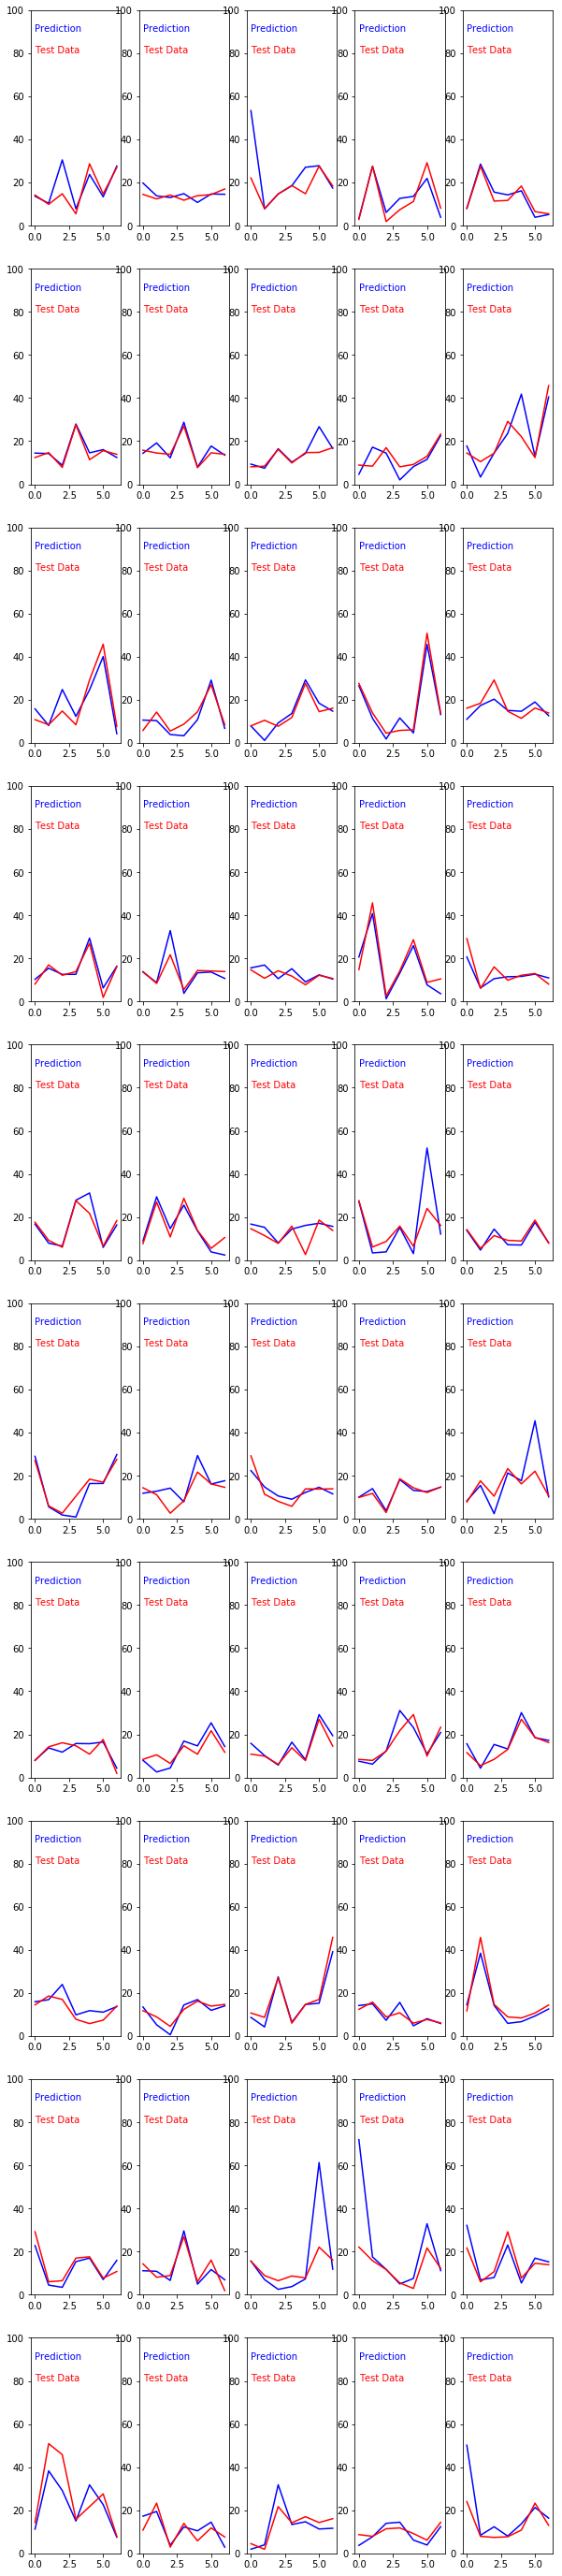

In [39]:
# Linear Regression
lm_model = LinearRegression(normalize=True)
all_mse_lm = predicting_soc_diff (X_variables, y_variable, lm_model)

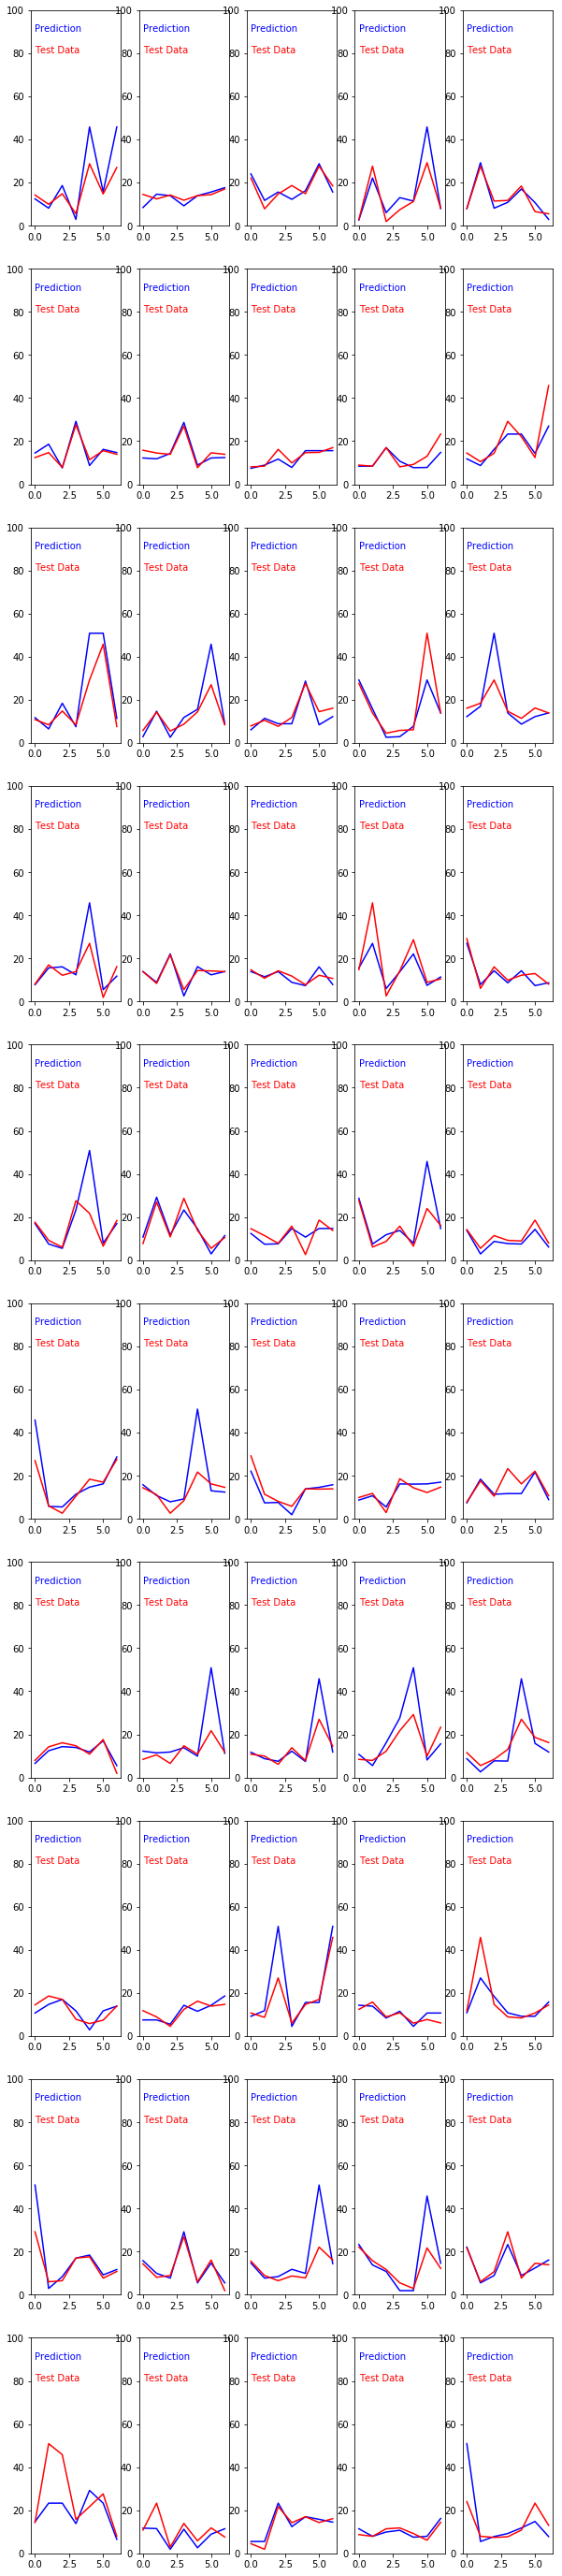

In [23]:
# Decision Tree
tree_model = DecisionTreeRegressor()
all_mse_tree = predicting_soc_diff (X_variables, y_variable, tree_model)

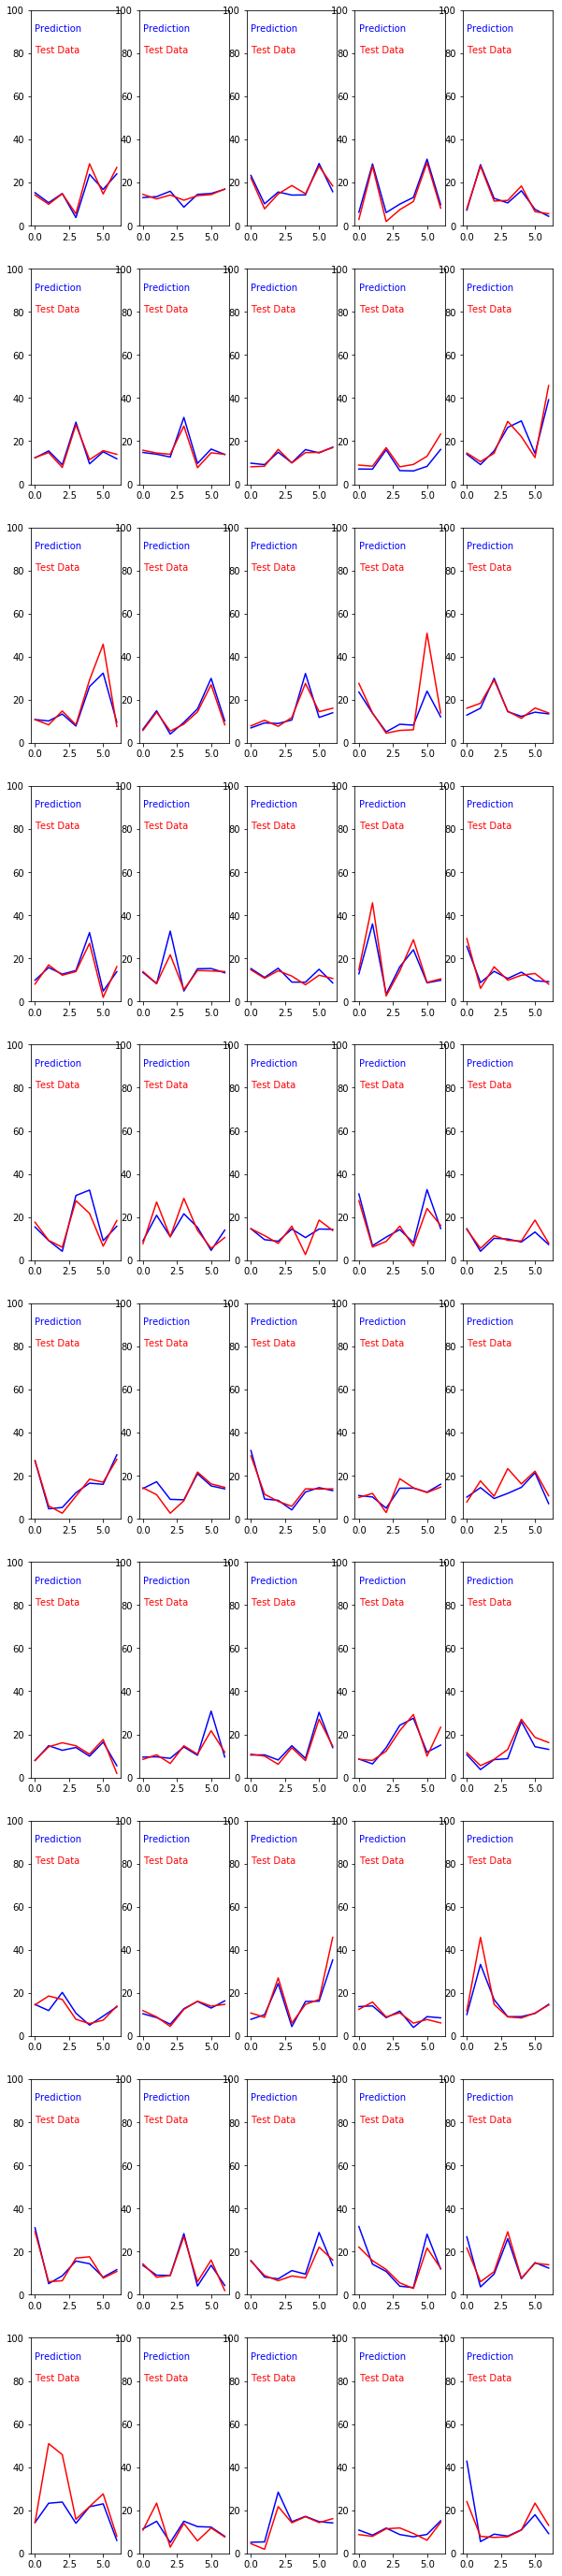

In [24]:
# RandomForestRegressor
rfr_model = RandomForestRegressor()
all_mse_rfr = predicting_soc_diff (X_variables, y_variable, rfr_model)

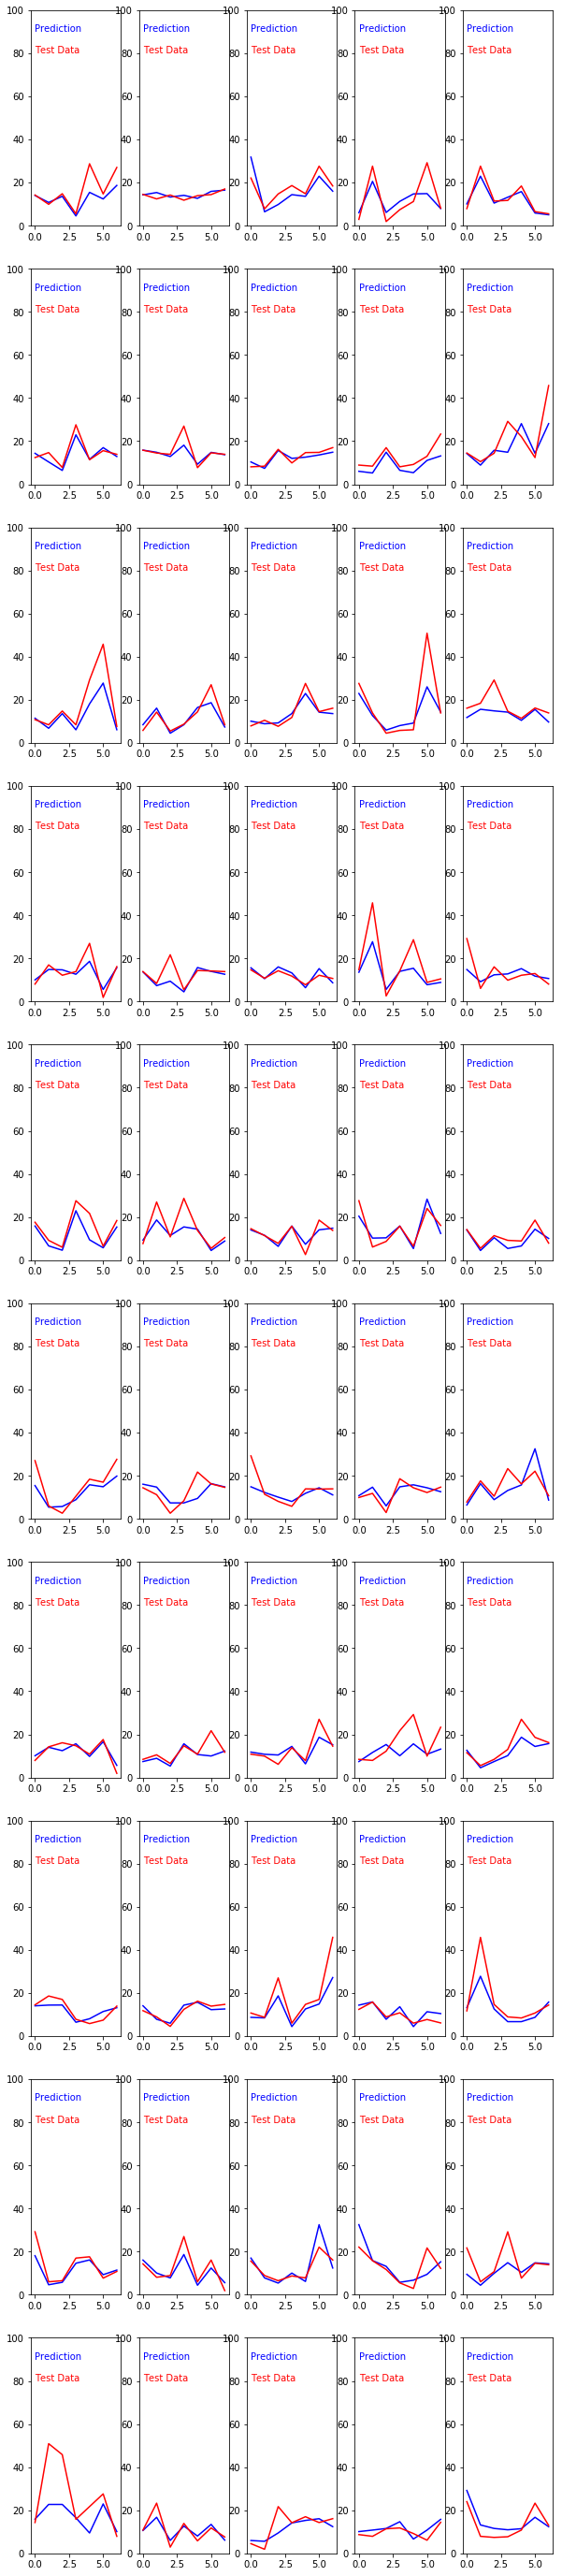

In [25]:
# KNeighborsRegressor
knn_model = KNeighborsRegressor()
all_mse_knn = predicting_soc_diff (X_variables, y_variable, knn_model)

# Step 5 | Evaluation

As a mean to compare the four regression techniques, we use the mean squared error and a boxplot visualisation.

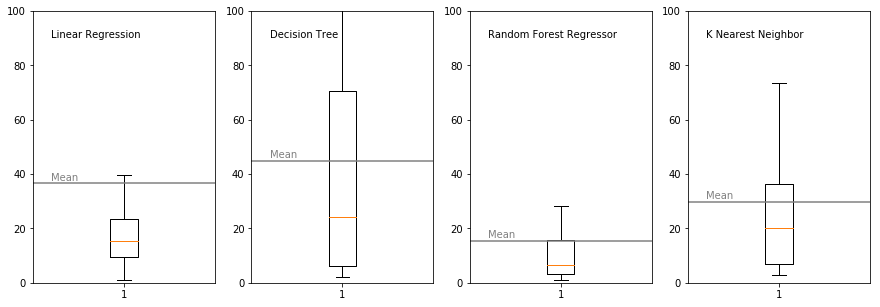

In [26]:
# Comparison of regression techniques
all_mse = [all_mse_lm, all_mse_tree, all_mse_rfr, all_mse_knn]
title = ['Linear Regression', 'Decision Tree', 'Random Forest Regressor', 'K Nearest Neighbor']

plt.rcParams['figure.figsize'] = [15, 5]
gs = grd.GridSpec(1, 4)

for m in range(0, len(all_mse)):        
    ax = plt.subplot(gs[m])
    ax.boxplot(all_mse[m], showfliers=False)
    ax.axhline(y=np.mean(all_mse[m]), color='grey', linestyle='-')
    ax.text(0.6,np.mean(all_mse[m])+1,'Mean', color='grey')
    ax.set_ylim(0, 100)
    ax.text(0.6, 90, title[m], color='black')
    
plt.show()

In [27]:
print('The mean of mean-squared-errors for the prediction with the Random Forest Regressor is: ', np.mean(all_mse_rfr)) 
print('The median of mean-squared-errors for the Random Forest Regressor is even lower with: ', np.median(all_mse_rfr))

The mean of mean-squared-errors for the prediction with the Random Forest Regressor is:  15.451609714285715
The median of mean-squared-errors for the Random Forest Regressor is even lower with:  6.524978571428582


Comparing all four regression techniques (Linear Regression, Decision Tree, Random Forest Regression, and K Nearest Neighbor), we see that the Random Forest Regression yields the best results. The three other regression techniques have significantly higher means and medians of the mean squared error.

# Step 6 | Hyperparameter Tuning

Now that we found a promising regression technique, we want to tune the hyperparamters to see if we can improve our prediction results. The hyperparameters for the Random Forest Regression are:
- Number of estimators, i.e. the number of trees the random forest is made up of
- Maximum number of features, i.e. how many features should be considered for splitting a tree from which the algortihm then chooses the best split


In [76]:
number_of_estimators = [10,30,50,70]
maximum_number_of_features = [float(0.7),float(0.8),float(0.9),float(1.0)]

hyp_tuning_results = []

for e in range(0, len(number_of_estimators)):
    for f in range(0, len(maximum_number_of_features)):
        
        print('Calculating | Number of estimators: ', number_of_estimators[e], 
              ' Maximum Number of Features: ', maximum_number_of_features[f]*100, '%')
        
        rfr = RandomForestRegressor(n_estimators=number_of_estimators[e], max_features=maximum_number_of_features[f])
        mse = predicting_soc_diff (X_variables, y_variable, rfr, plot=False)
        
        hyp_tuning_results.append((number_of_estimators[e], maximum_number_of_features[f], 
                                   np.mean(mse), np.median(mse)))

Calculating | Number of estimators:  10  Maximum Number of Features:  70.0 %
Calculating | Number of estimators:  10  Maximum Number of Features:  80.0 %
Calculating | Number of estimators:  10  Maximum Number of Features:  90.0 %
Calculating | Number of estimators:  10  Maximum Number of Features:  100.0 %
Calculating | Number of estimators:  30  Maximum Number of Features:  70.0 %
Calculating | Number of estimators:  30  Maximum Number of Features:  80.0 %
Calculating | Number of estimators:  30  Maximum Number of Features:  90.0 %
Calculating | Number of estimators:  30  Maximum Number of Features:  100.0 %
Calculating | Number of estimators:  50  Maximum Number of Features:  70.0 %
Calculating | Number of estimators:  50  Maximum Number of Features:  80.0 %
Calculating | Number of estimators:  50  Maximum Number of Features:  90.0 %
Calculating | Number of estimators:  50  Maximum Number of Features:  100.0 %
Calculating | Number of estimators:  70  Maximum Number of Features:  70.

In [79]:
hyp_tuning_results_df = pd.DataFrame(hyp_tuning_results, 
                                     columns=['Number Estimators', 'Maximum Number of Features', 'Mean', 'Median'])

In [80]:
hyp_tuning_results_df[hyp_tuning_results_df['Mean'] == hyp_tuning_results_df['Mean'].min()]

,Number Estimators,Maximum Number of Features,Mean,Median
8,50,0.7,12.891523,4.930501


In [81]:
hyp_tuning_results_df[hyp_tuning_results_df['Median'] == hyp_tuning_results_df['Median'].min()]

,Number Estimators,Maximum Number of Features,Mean,Median
8,50,0.7,12.891523,4.930501


We can see, that the hyperparameter tuning led us to better results. Using 50 trees in the forest and 70 % of features for choosing the best split, we receive the following results:

In [83]:
print('The best mean of mean-squared-errors for the prediction after hyperparameter tuning is: ', 
      hyp_tuning_results_df['Mean'].min()) 
print('The best median of mean-squared-errors for the prediction after hyperparameter tuning is: ', 
      hyp_tuning_results_df['Median'].min())

The best mean of mean-squared-errors for the prediction after hyperparameter tuning is:  12.89152321142857
The best median of mean-squared-errors for the prediction after hyperparameter tuning is:  4.930501142857144


# What Remains to be Said

The data used within this Notebook has been downloaded from Kaggle (https://www.kaggle.com/atechnohazard/battery-and-heating-data-in-real-driving-cycles). It has originally been published by Matthias Steinstraeter (Technical University of Munich, Institute of Automotive Technology), Johannes Buberger (Technical University of Munich, Institute of Automotive Technology), and Dimitar Trifonov (Technical University of Munich, Institute of Automotive Technology) in IEEE Data Portal (https://ieee-dataport.org/open-access/battery-and-heating-data-real-driving-cycles).

Author of this Notebook is: F B

This notebook has been created as part of the capstone project of Udacity's Data Scientist program.

Created in March 2022